# Prediction_of_H1N1_vaccination
Your task is to predict whether people got H1N1 vaccines using information they shared about their backgrounds, opinions, and health behaviors.



## Data Understanding

### Import Libraries and Data

In [697]:
import pandas as pd
import numpy as np
import scipy
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from IPython.display import clear_output
import category_encoders
from autoimpute.imputations import SingleImputer, MultipleImputer, MiceImputer

clear_output();
%matplotlib inline


In [698]:
train = pd.read_csv('../Prediction_of_H1N1_vaccination/data/train.csv')
target = pd.read_csv('../Prediction_of_H1N1_vaccination/data/train_labels.csv')
test = pd.read_csv('../Prediction_of_H1N1_vaccination/data/test.csv')
submission = pd.read_csv('../Prediction_of_H1N1_vaccination/data/submission.csv')

In [699]:
train.shape, target.shape, test.shape, submission.shape

((42154, 38), (42154, 2), (28104, 38), (28104, 2))

In [700]:
df=pd.concat([train,target],axis=1)
df.shape

(42154, 40)

In [701]:
np.random.seed(42)

### Data Describe and EDA

#### Pandas Profiling

In [702]:
#ProfileReport(df, title="Pandas Profiling Report", explorative=True)

In [703]:
def EDA_plot1(df,column):
    uniqs = len(df[column].dropna().unique())
    #히스토그램, 박스플롯
    if pd.api.types.is_numeric_dtype(df[column]) and uniqs>30:
        ax = sns.boxplot(x=df[column])
        plt.show()
    if uniqs<=10:
        #바플롯세로
        ax=sns.countplot(x=column,data=df)
        for p in ax.patches:
            percentage = f'{100 * p.get_height() / len(df):.1f}%\n'
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax.annotate(percentage, (x, y), ha='center', va='center')
        plt.tight_layout()
        plt.show()

    else:
        fig, ax = plt.subplots(figsize=(8,4+uniqs/3),nrows=1,ncols=1)
        ax=sns.countplot(y=column,data=df)
        plt.tight_layout()
        plt.show()


In [704]:
def EDA_plot2(df,type_dict,column):
    uniqs = len(df[column].dropna().unique())
    if type_dict[column]=='bool':
        pass
    elif type_dict[column]=='category':
        pass
    elif type_dict[column]=='ordered_category':
        pass
    elif type_dict[column]=='int':
        pass
    elif type_dict[column]=='float':
        pass

In [705]:
def rdplot(df,column_name,rot=0):
    fig1, axs1 = plt.subplots(figsize=(16,6),nrows=1,ncols=2)
    order=sorted(df[f'{column_name}'].dropna().unique())
    ax1=sns.countplot(x=f'{column_name}', data=df[df['vacc_h1n1_f']==0],ax=axs1[0], order=order)
    ax2=sns.countplot(x=f'{column_name}', data=df[df['vacc_h1n1_f']==1],ax=axs1[1], order=order)
    ax1.tick_params(rotation=rot)
    ax2.tick_params(rotation=rot)
    ax1.set_title(f'category count of {column_name} column when target=0')
    ax2.set_title(f'category count of {column_name} column when target=1')
    
    
    col_sum0=df[df['vacc_h1n1_f']==0].groupby(f'{column_name}').count()['vacc_h1n1_f'].sum()
    col_sum1=df[df['vacc_h1n1_f']==1].groupby(f'{column_name}').count()['vacc_h1n1_f'].sum()
    a=df[df['vacc_h1n1_f']==0].groupby(f'{column_name}').count()['vacc_h1n1_f'].apply(lambda x: x/col_sum0*100)
    b=df[df['vacc_h1n1_f']==1].groupby(f'{column_name}').count()['vacc_h1n1_f'].apply(lambda x: x/col_sum1*100)
    c=(a-b).apply(lambda x: abs(x)).reset_index()
    fig2, axs2 = plt.subplots(figsize=(16,10),nrows=1,ncols=1)
    ax3=sns.barplot(x=f'{column_name}',y='vacc_h1n1_f',data=c,ax=axs2)
    ax3.tick_params(rotation=rot)
    ax3.set_title(f'ratio difference of counts of each categories of "{column_name}" columns by target')
    return

In [706]:
categorical_encoding_needed=[]

#### Univariate analysis

Including Data re-expression, type casting, Outliers

##### (target) vacc_h1n1_f

- Description : Whether respondent received H1N1 flu vaccine.

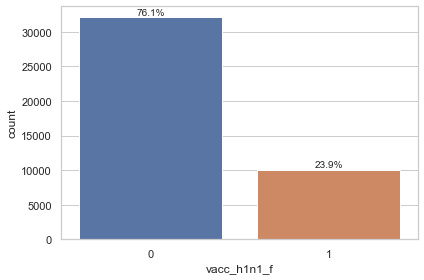

In [707]:
EDA_plot1(df,'vacc_h1n1_f')

- Note : boolean, Imbalanced Data

In [708]:
df['vacc_h1n1_f']=df['vacc_h1n1_f'].replace(1,True).replace(0,False)

##### vacc_seas_f

- Description : Whether respondent received seasonal flu vaccine.

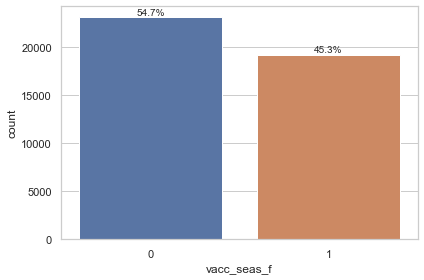

In [709]:
EDA_plot1(df,'vacc_seas_f')

- Note : boolean, Imbalanced Data, dependent variable

In [710]:
df['vacc_seas_f']=df['vacc_seas_f'].replace(1,True).replace(0,False)

##### h1n1_concern 

- Description : Level of concern about the H1N1 flu.   
0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.   

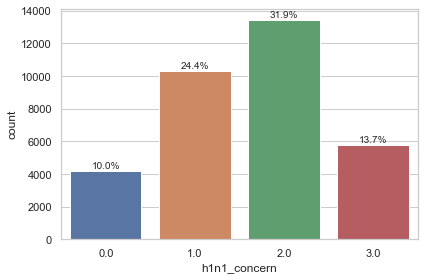

In [711]:
EDA_plot1(df,'h1n1_concern')

- Note : ordinal categorical type

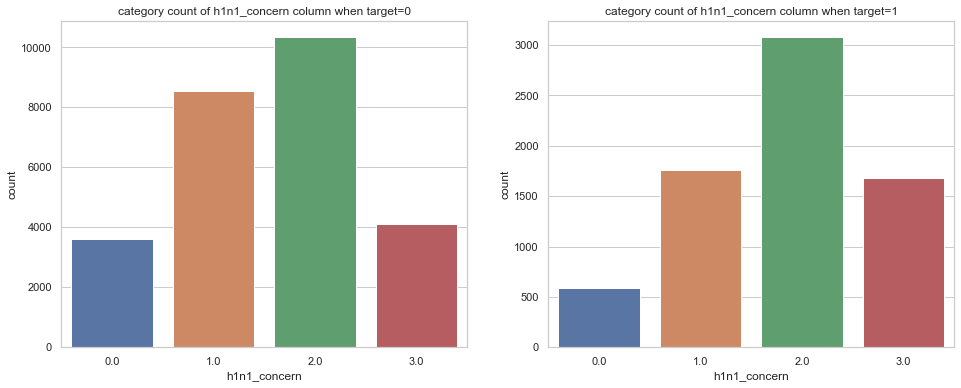

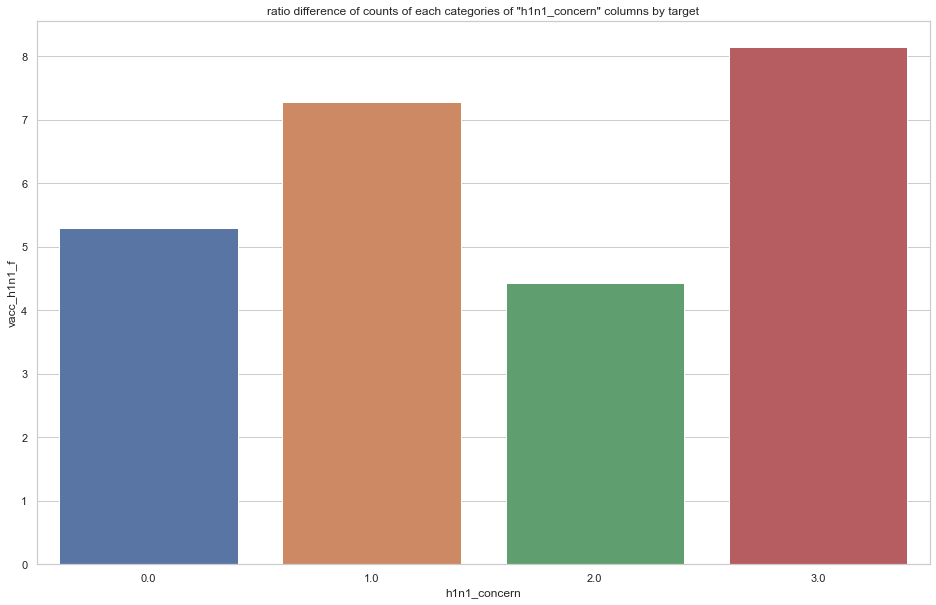

In [712]:
rdplot(df,'h1n1_concern')

##### h1n1_knowledge

- Description : Level of knowledge about H1N1 flu.   
0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.   

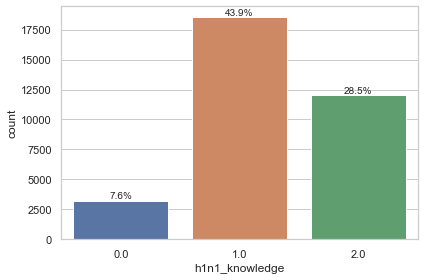

In [713]:
EDA_plot1(df,'h1n1_knowledge')

- Note : ordinal categorical type

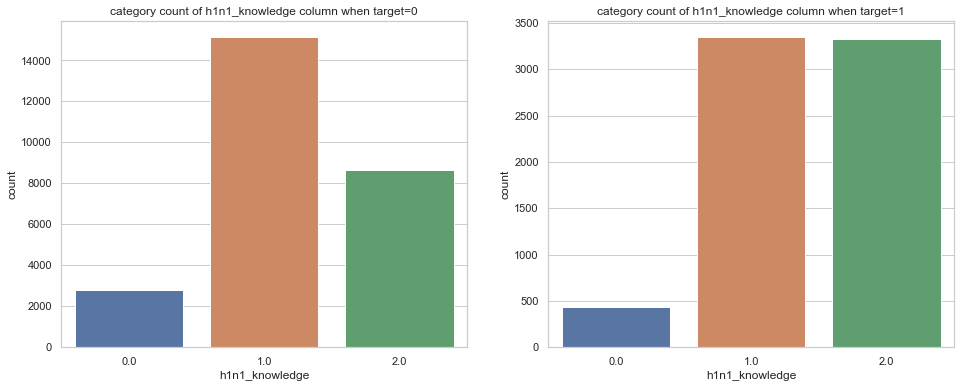

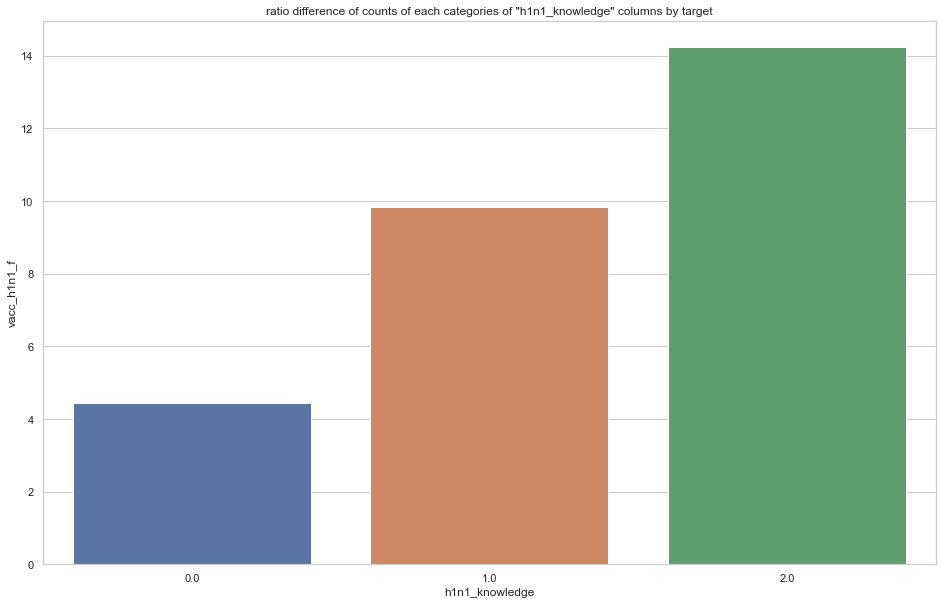

In [714]:
rdplot(df,'h1n1_knowledge')

##### behavioral_antiviral_meds

- Description : Has taken antiviral medications.

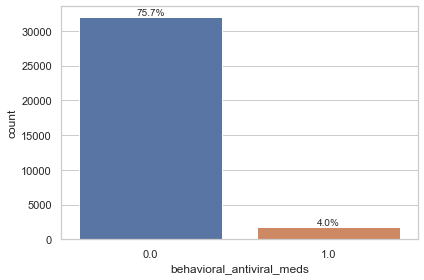

In [715]:
EDA_plot1(df,'behavioral_antiviral_meds')

- Note : boolean, Imbalanced

In [716]:
df['behavioral_antiviral_meds']=df['behavioral_antiviral_meds'].replace(1,True).replace(0,False)

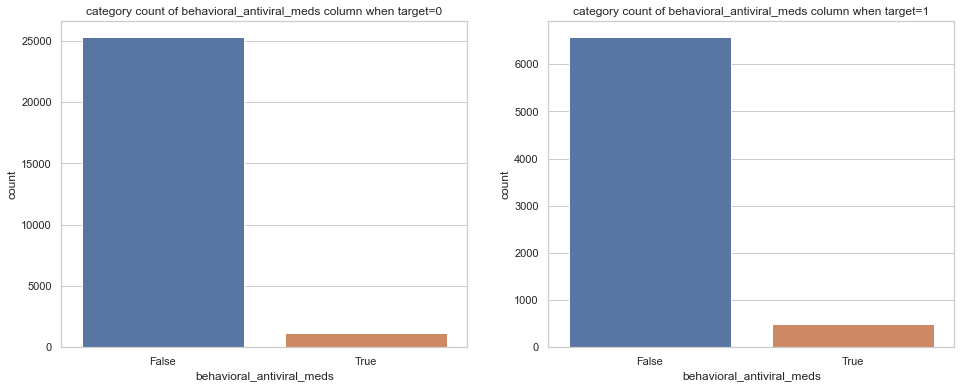

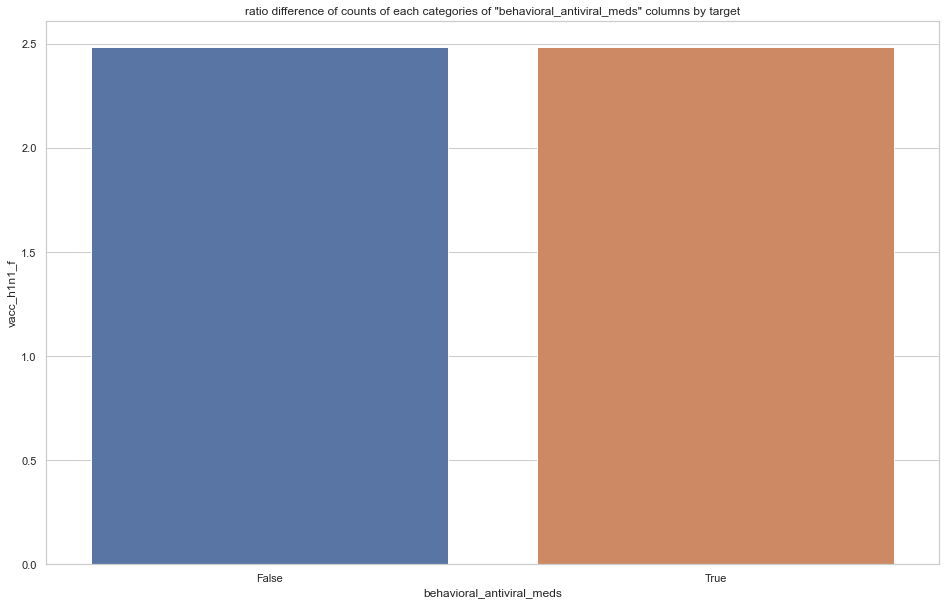

In [717]:
rdplot(df,'behavioral_antiviral_meds')

##### behavioral_avoidance

- Description : Has avoided close contact with others with flu-like symptoms.

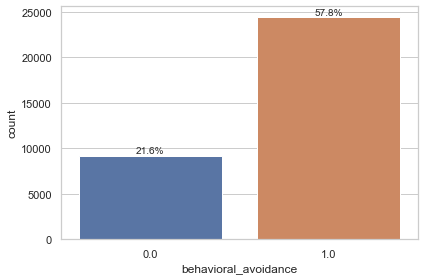

In [718]:
EDA_plot1(df,'behavioral_avoidance')

- Note : boolean

In [719]:
df['behavioral_avoidance']=df['behavioral_avoidance'].replace(1,True).replace(0,False)

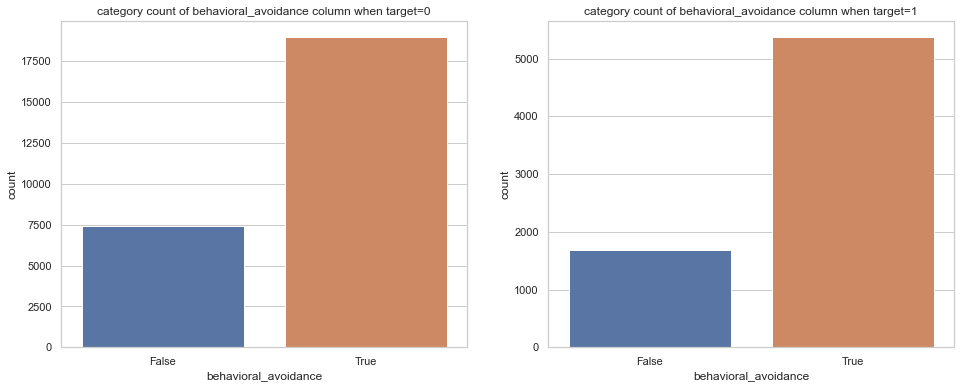

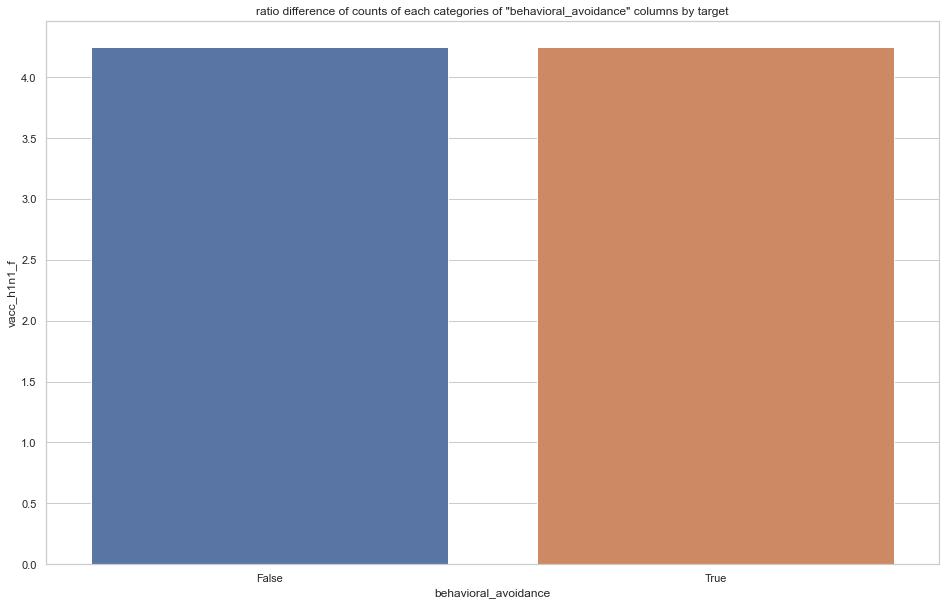

In [720]:
rdplot(df,'behavioral_avoidance')

##### behavioral_face_mask

- Description : Has bought a face mask.

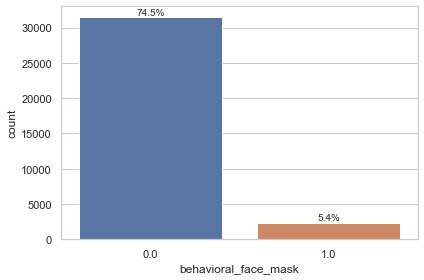

In [721]:
EDA_plot1(df,'behavioral_face_mask')

- Note : boolean, Imbalanced

In [722]:
df['behavioral_face_mask']=df['behavioral_face_mask'].replace(1,True).replace(0,False)

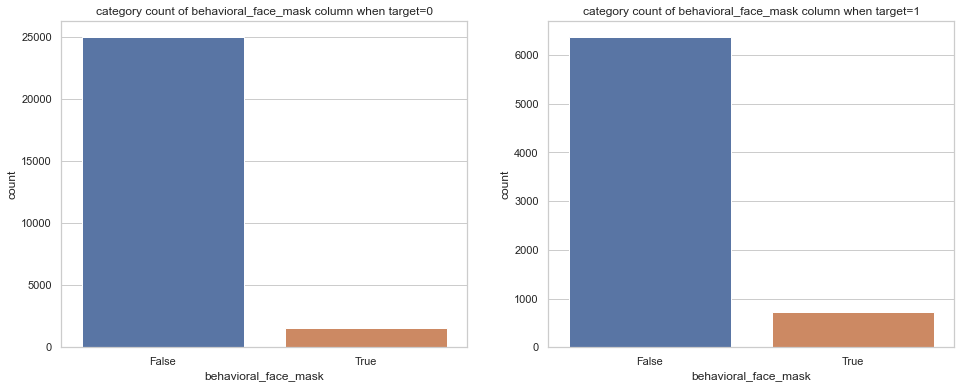

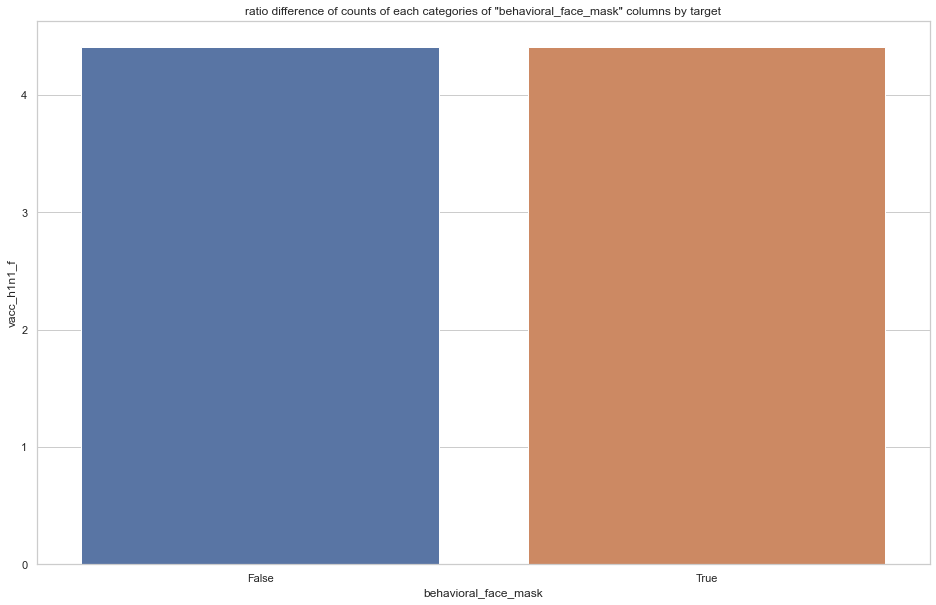

In [723]:
rdplot(df,'behavioral_face_mask')

##### behavioral_wash_hands

- Description : Has frequently washed hands or used hand sanitizer.

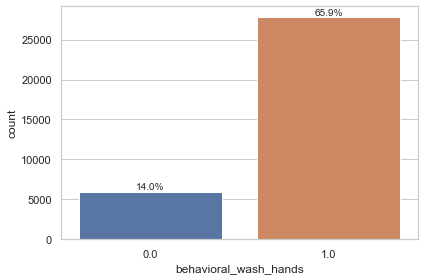

In [724]:
EDA_plot1(df,'behavioral_wash_hands')

- Note : boolean

In [725]:
df['behavioral_wash_hands']=df['behavioral_wash_hands'].replace(1,True).replace(0,False)

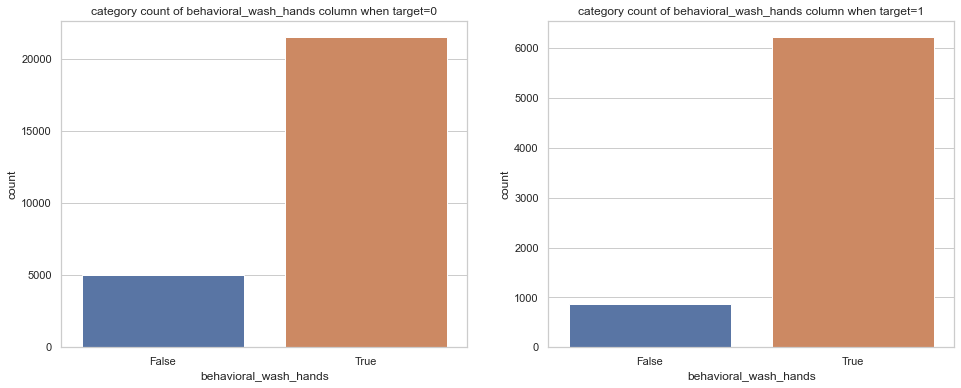

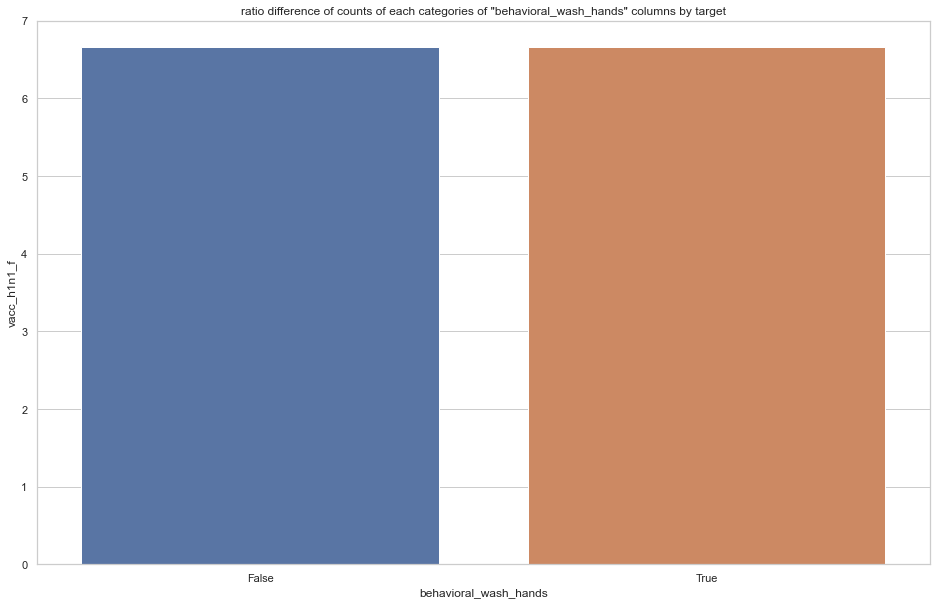

In [726]:
rdplot(df,'behavioral_wash_hands')

##### behavioral_large_gatherings

- Description : Has reduced time at large gatherings.

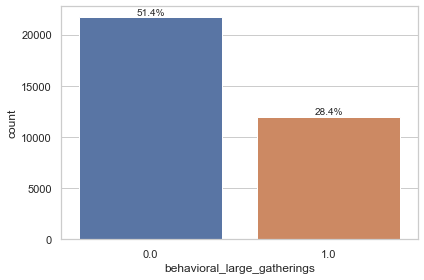

In [727]:
EDA_plot1(df,'behavioral_large_gatherings')

In [728]:
df['behavioral_large_gatherings']=df['behavioral_large_gatherings'].replace(1,True).replace(0,False)

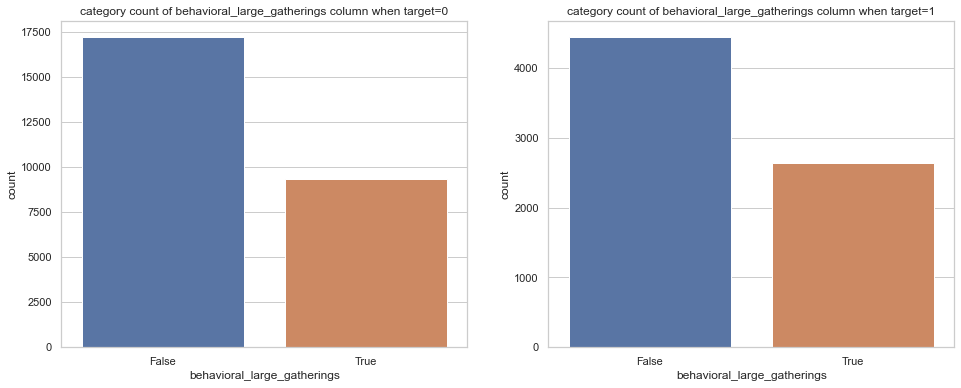

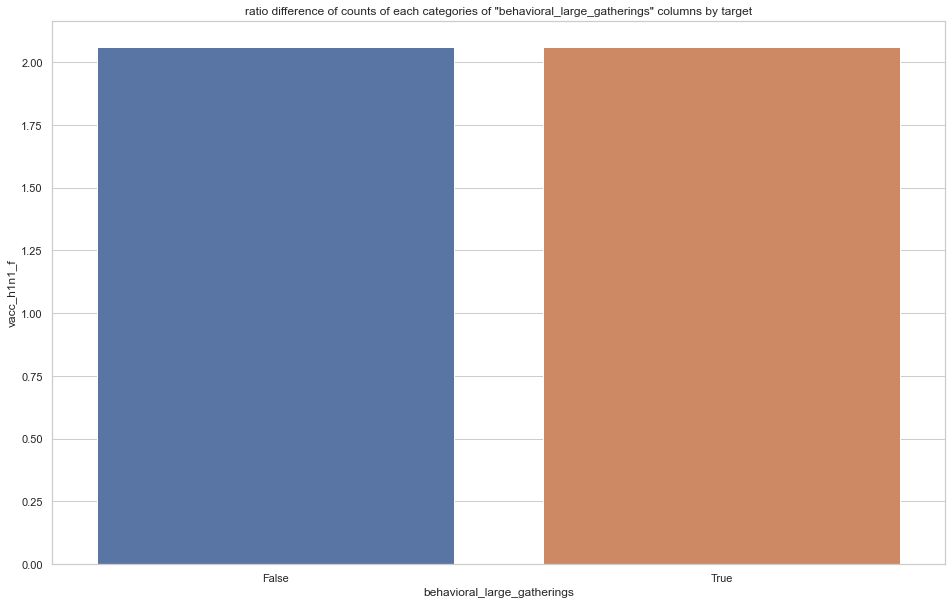

In [729]:
rdplot(df,'behavioral_large_gatherings')

##### behavioral_outside_home

- Description : Has reduced contact with people outside of own household.

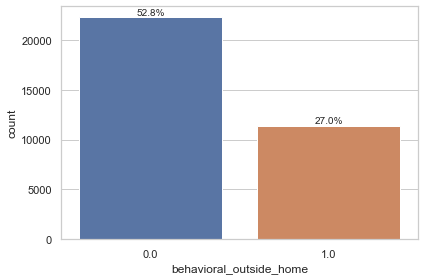

In [730]:
EDA_plot1(df,'behavioral_outside_home')

In [731]:
df['behavioral_outside_home']=df['behavioral_outside_home'].replace(1,True).replace(0,False)

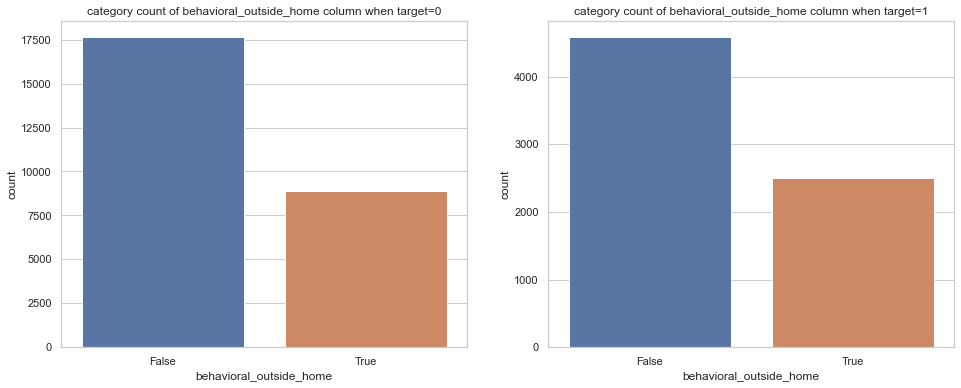

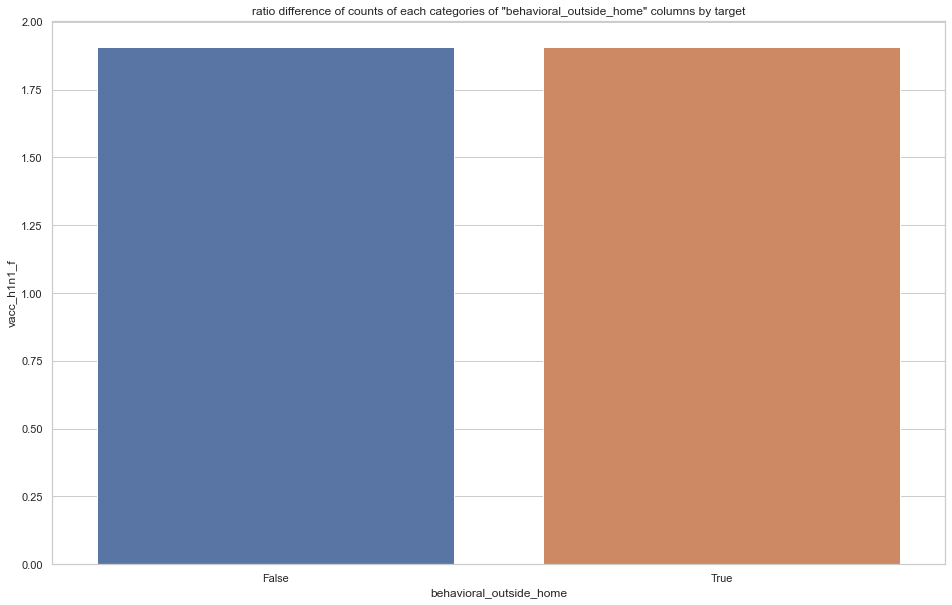

In [732]:
rdplot(df,'behavioral_outside_home')

##### behavioral_touch_face

- Description : Has avoided touching eyes, nose, or mouth.

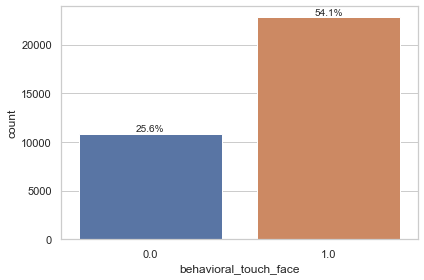

In [733]:
EDA_plot1(df,'behavioral_touch_face')

- Note : boolean

In [734]:
df['behavioral_touch_face']=df['behavioral_touch_face'].replace(1,True).replace(0,False)

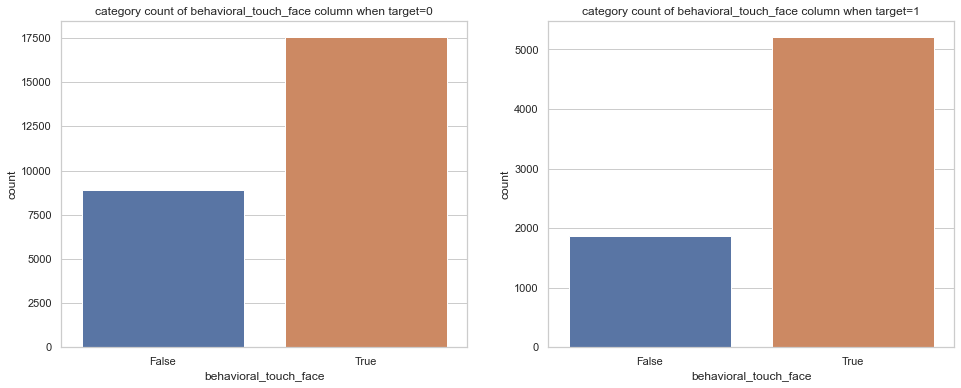

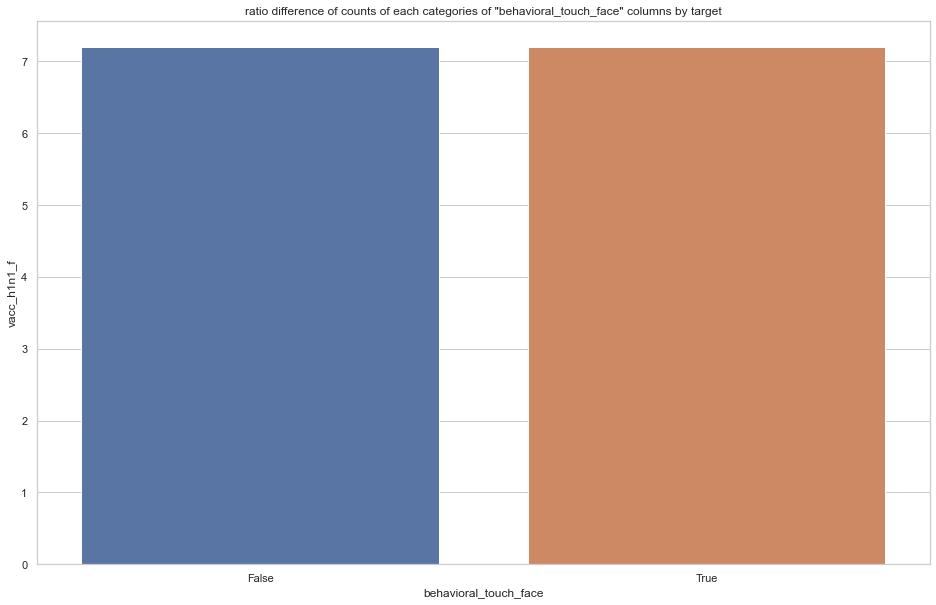

In [735]:
rdplot(df,'behavioral_touch_face')

##### doctor_recc_h1n1

- Description : H1N1 flu vaccine was recommended by doctor.

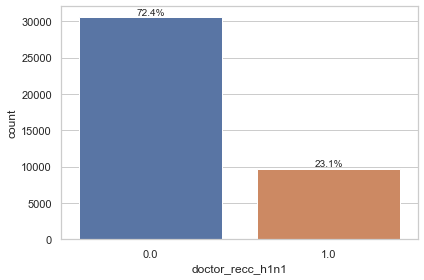

In [736]:
EDA_plot1(df,'doctor_recc_h1n1')

In [737]:
df['doctor_recc_h1n1']=df['doctor_recc_h1n1'].replace(1,True).replace(0,False)

- Note : boolean

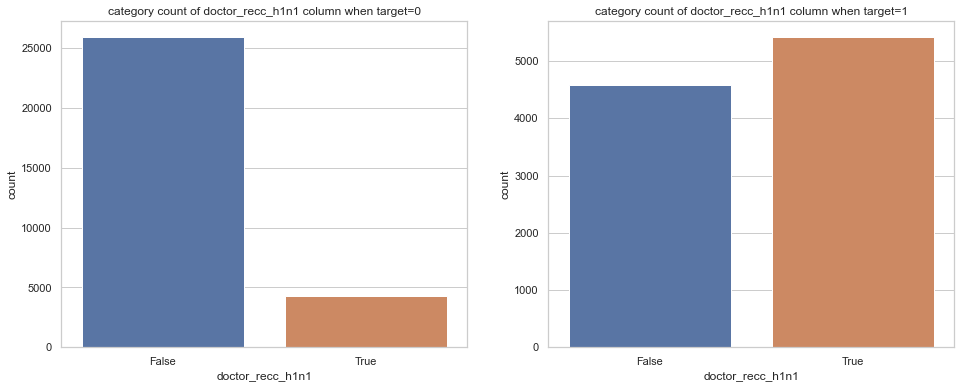

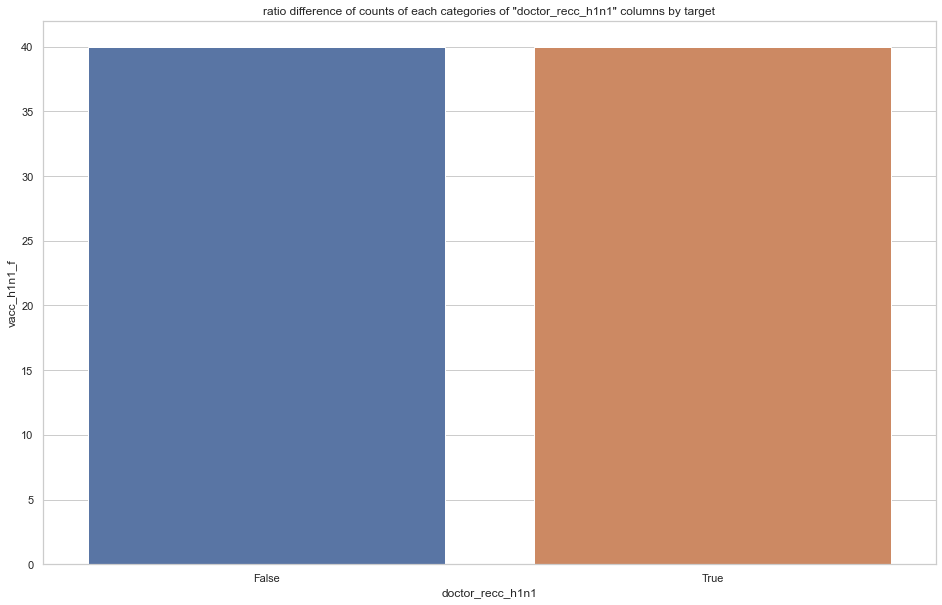

In [738]:
rdplot(df,'doctor_recc_h1n1')

##### doctor_recc_seasonal

- Description : Seasonal flu vaccine was recommended by doctor.

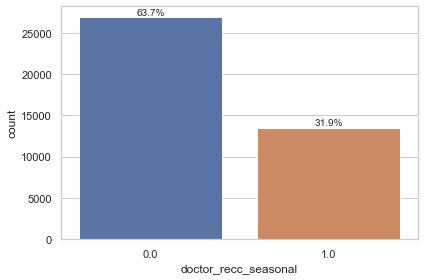

In [739]:
EDA_plot1(df,'doctor_recc_seasonal')

- Note : boolean, seasonal

In [740]:
df['doctor_recc_seasonal']=df['doctor_recc_seasonal'].replace(1,True).replace(0,False)

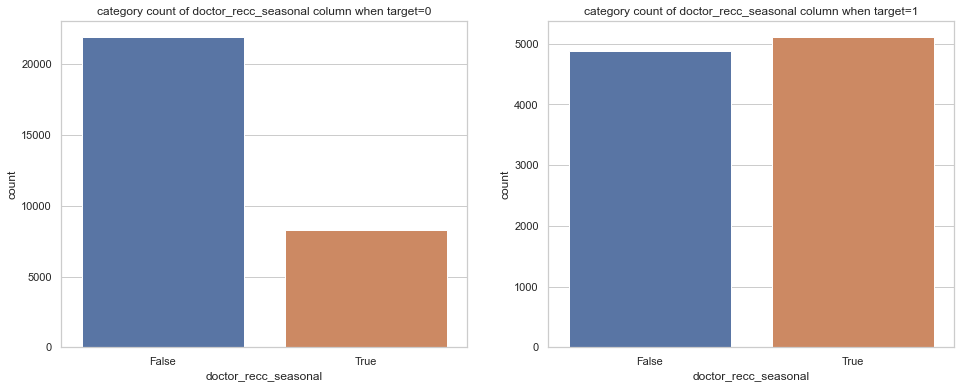

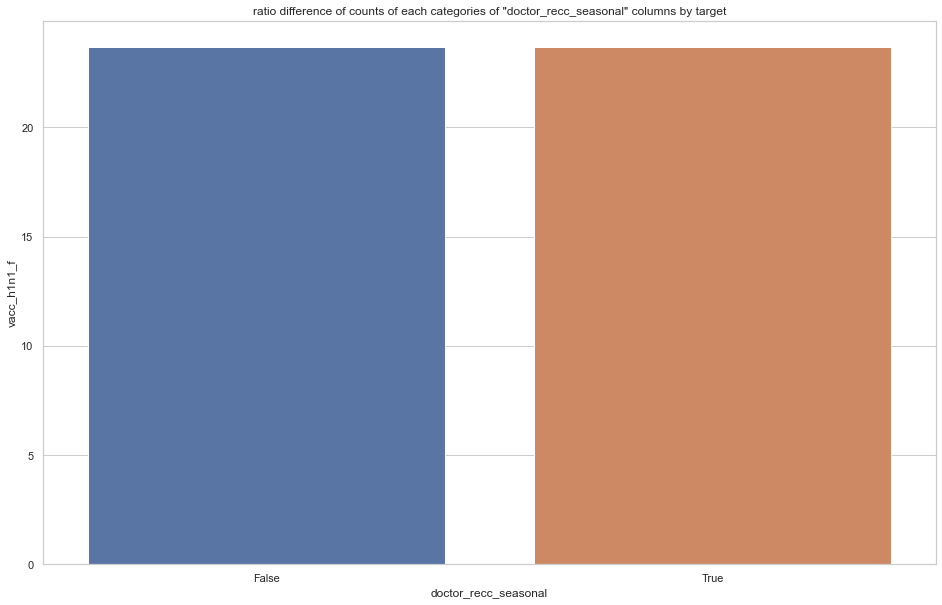

In [741]:
rdplot(df,'doctor_recc_seasonal')

##### chronic_med_condition

- Description : Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. 

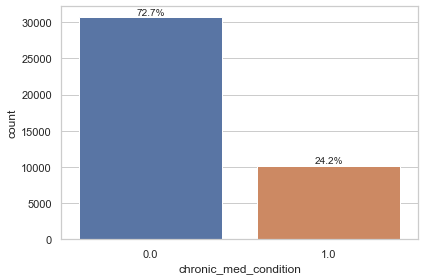

In [742]:
EDA_plot1(df,'chronic_med_condition')

- Note : boolean

In [743]:
df['chronic_med_condition']=df['chronic_med_condition'].replace(1,True).replace(0,False)

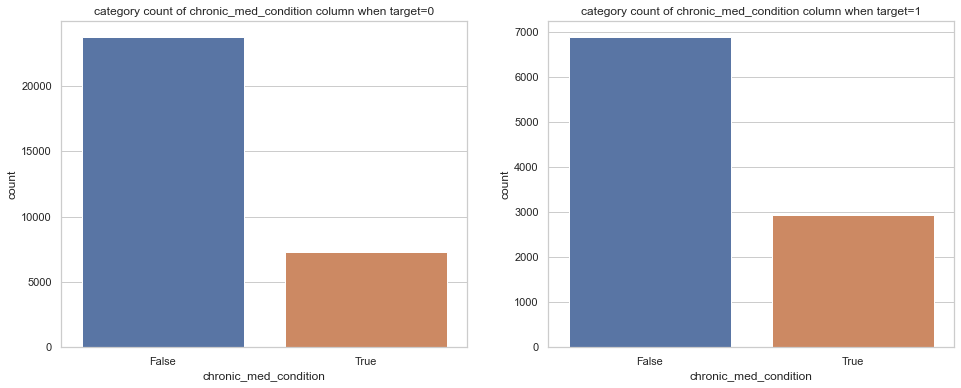

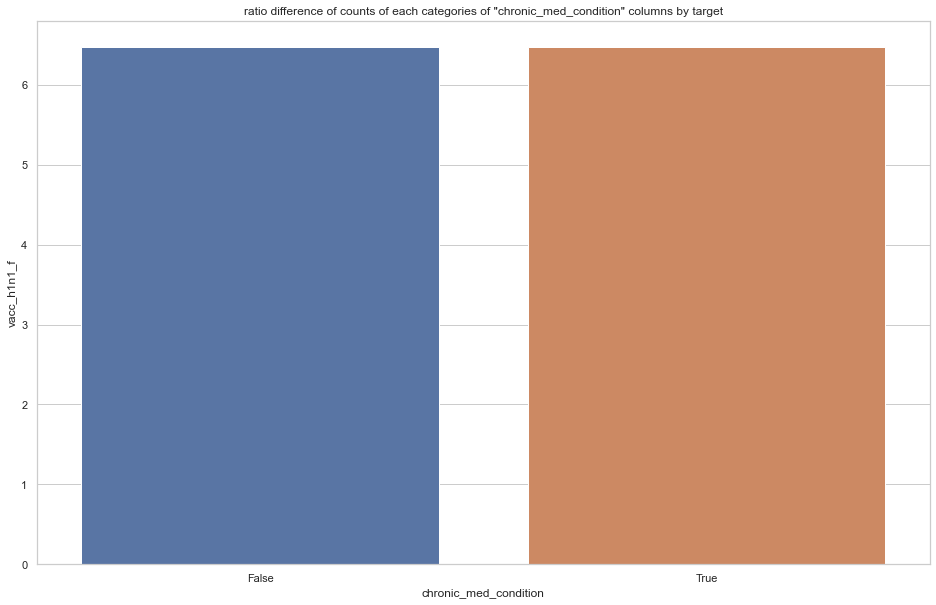

In [744]:
rdplot(df,'chronic_med_condition')

##### child_under_6_months

- Description : Has regular close contact with a child under the age of six months.

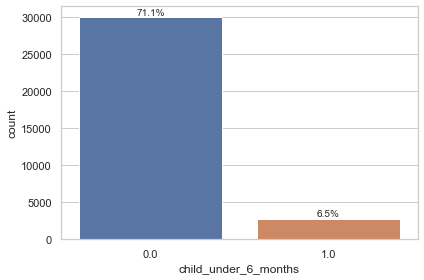

In [745]:
EDA_plot1(df,'child_under_6_months')

- Note : boolean, Imbalanced

In [746]:
df['child_under_6_months']=df['child_under_6_months'].replace(1,True).replace(0,False)

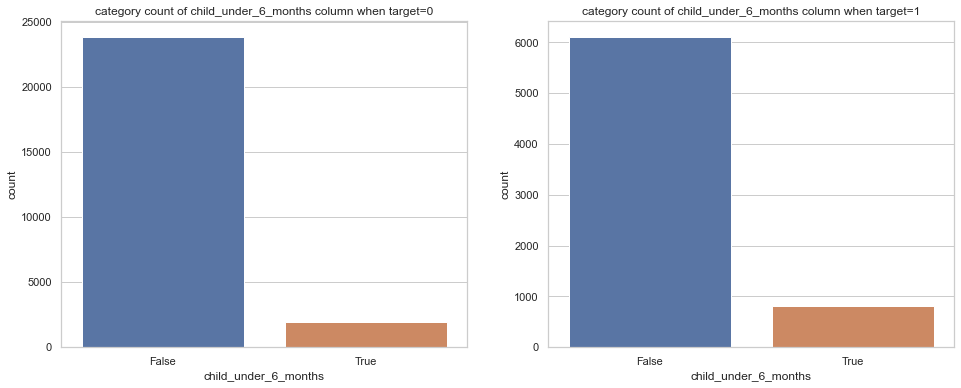

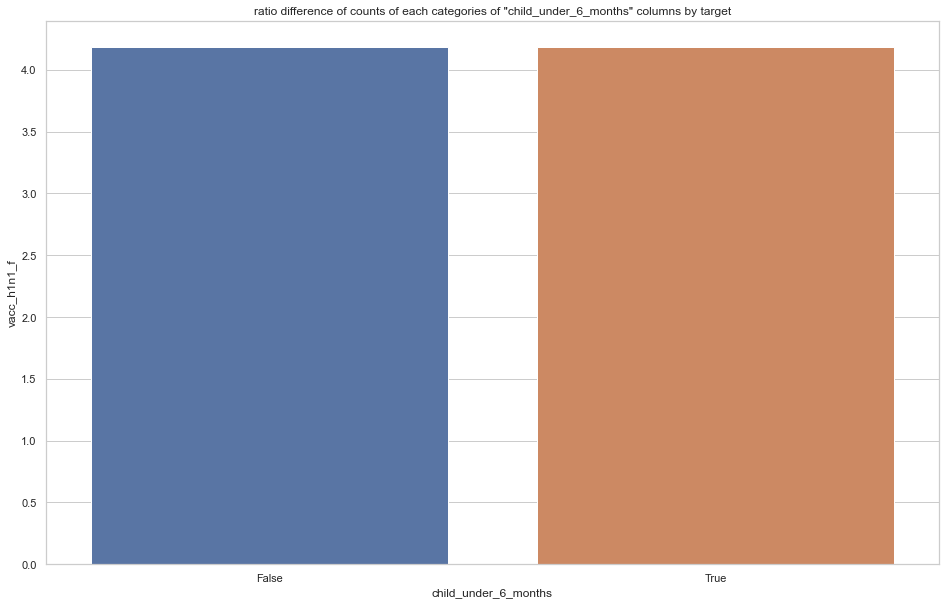

In [747]:
rdplot(df,'child_under_6_months')

##### health_insurance

- Description : Has health insurance.

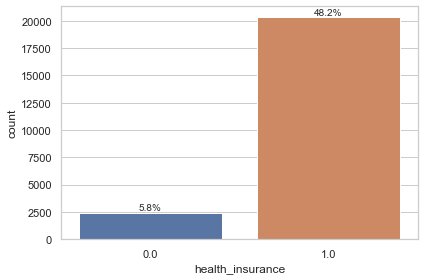

In [748]:
EDA_plot1(df,'health_insurance')

- Note : boolean

In [749]:
df['health_insurance']=df['health_insurance'].replace(1,True).replace(0,False)

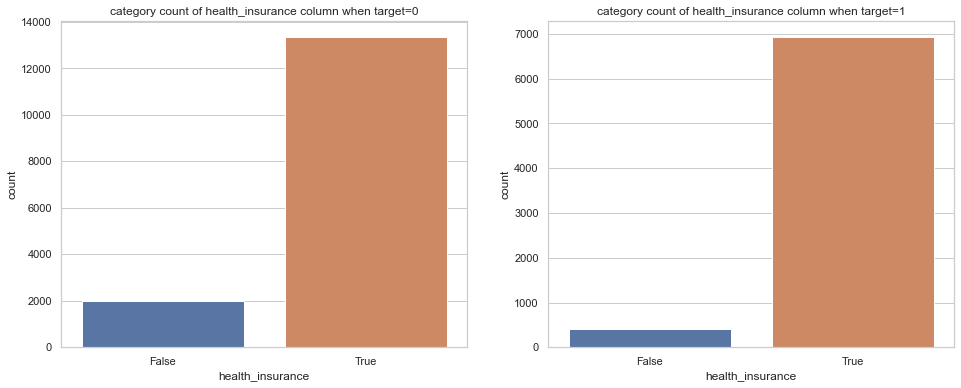

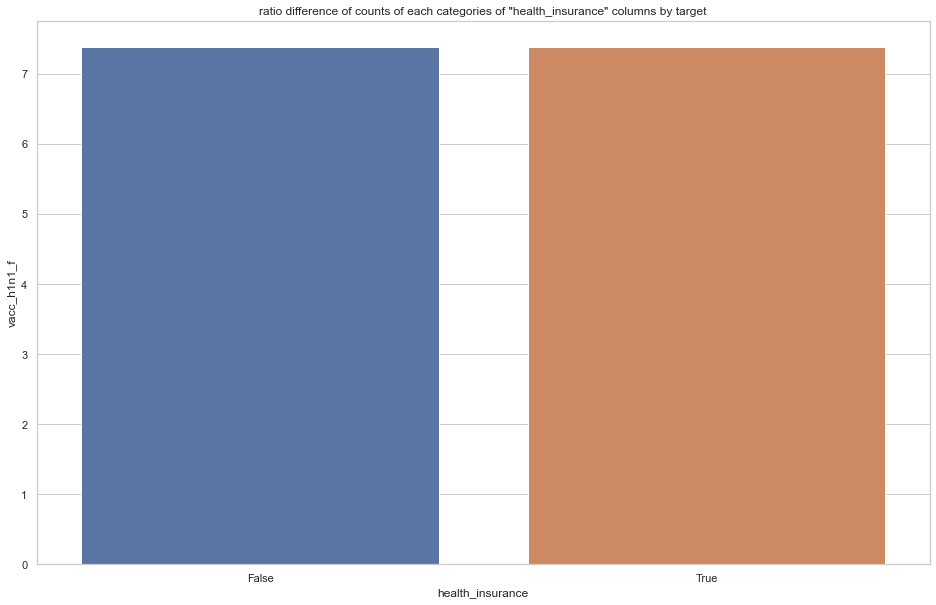

In [750]:
rdplot(df,'health_insurance')

##### health_worker

- Description : Is a healthcare worker.

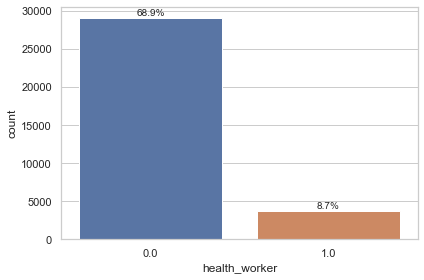

In [751]:
EDA_plot1(df,'health_worker')

- Note : boolean

In [752]:
df['health_worker']=df['health_worker'].replace(1,True).replace(0,False)

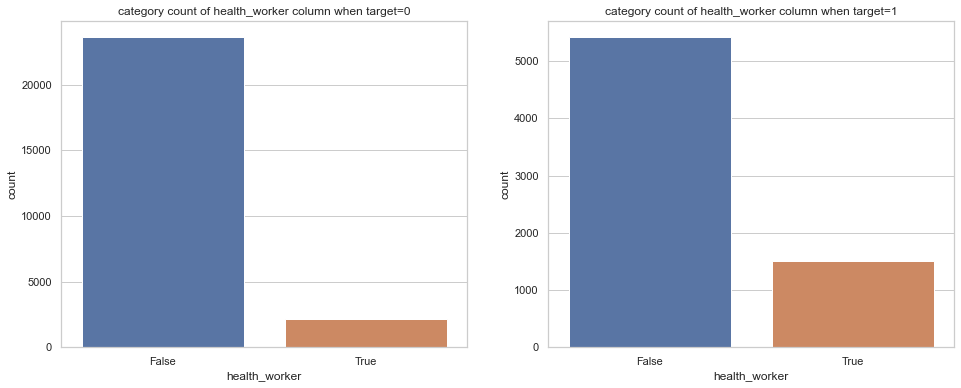

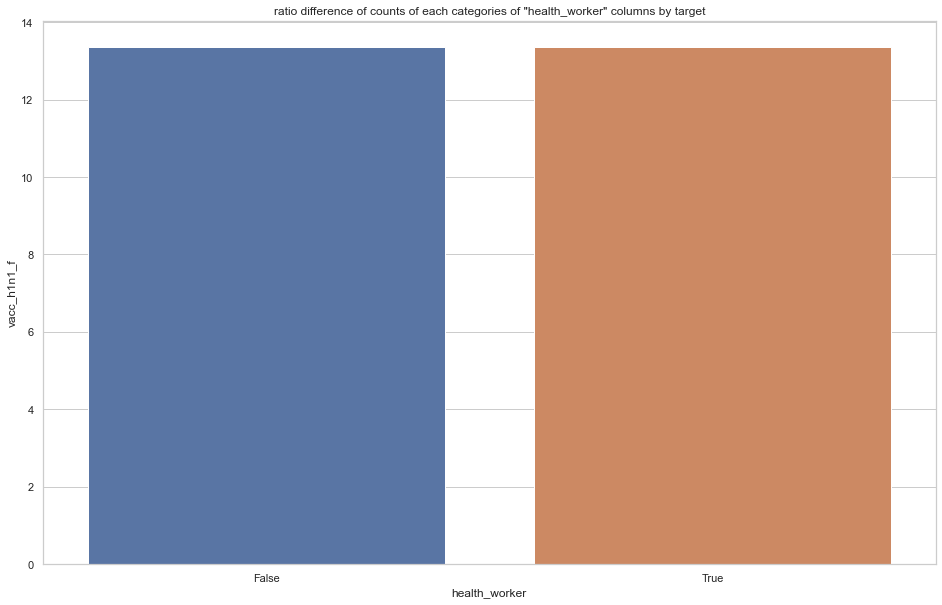

In [753]:
rdplot(df,'health_worker')

##### opinion_h1n1_vacc_effective

- Description : Respondent's opinion about H1N1 vaccine effectiveness.   

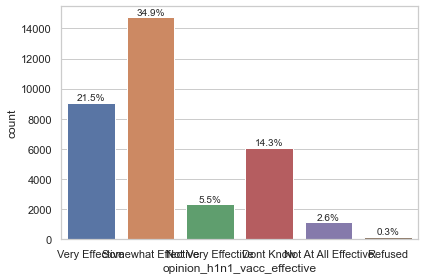

In [754]:
EDA_plot1(df,'opinion_h1n1_vacc_effective')

- Note : ordered categorical type, Don't Know/Refused -> nan

In [755]:
df['opinion_h1n1_vacc_effective'].replace('Dont Know',np.nan,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Refused',np.nan,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Not At All Effective',0,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Not Very Effective',1,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Somewhat Effective',2,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Very Effective',3,inplace=True)

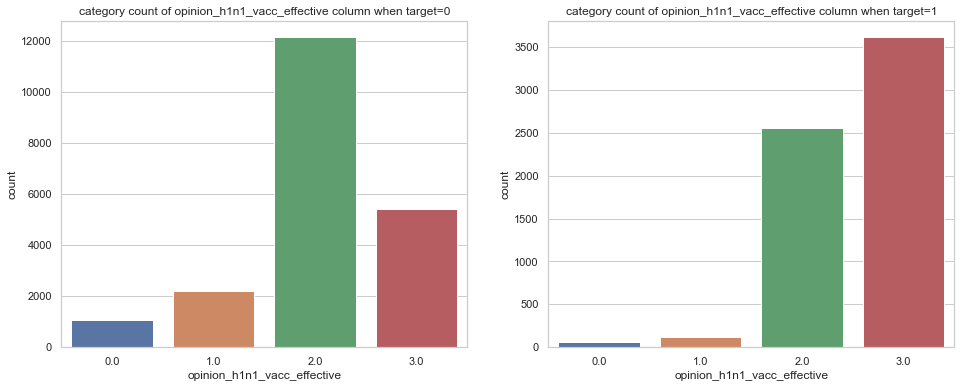

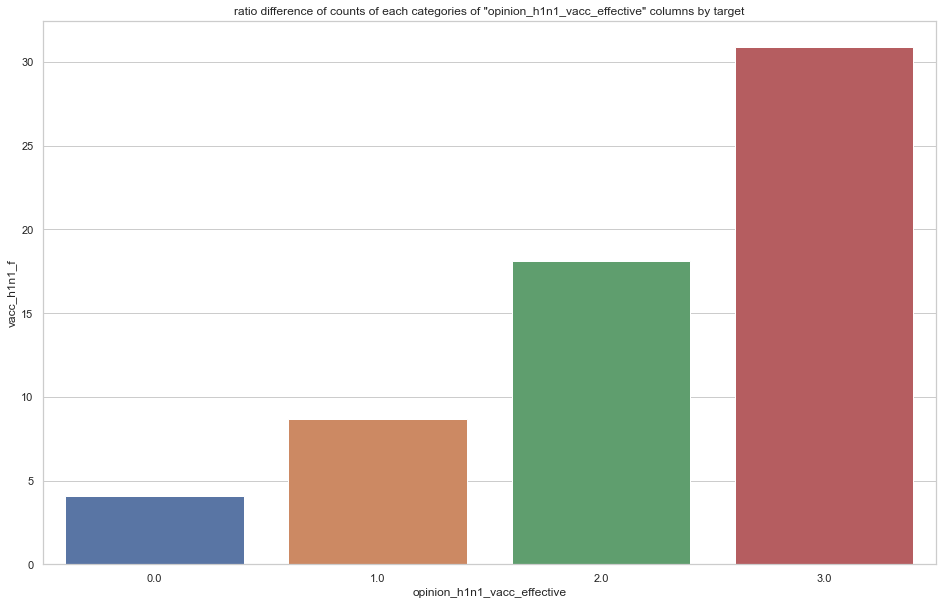

In [756]:
rdplot(df,'opinion_h1n1_vacc_effective')

##### opinion_h1n1_risk
Remarks : Don't Know, Refused -> nan

- Description : Respondent's opinion about risk of getting sick with H1N1 flu without vaccine.  

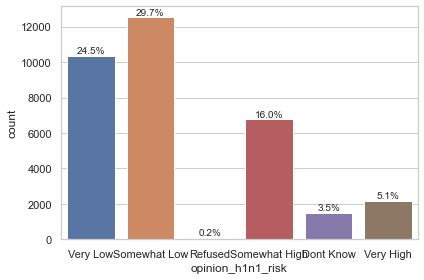

In [757]:
EDA_plot1(df,'opinion_h1n1_risk')

- Note : ordered categorical type, Don't Know/Refused -> nan

In [758]:
df['opinion_h1n1_risk'].replace('Dont Know',np.nan,inplace=True)
df['opinion_h1n1_risk'].replace('Refused',np.nan,inplace=True)
df['opinion_h1n1_risk'].replace('Very Low',1,inplace=True)
df['opinion_h1n1_risk'].replace('Somewhat Low',2,inplace=True)
df['opinion_h1n1_risk'].replace('Somewhat High',3,inplace=True)
df['opinion_h1n1_risk'].replace('Very High',4,inplace=True)

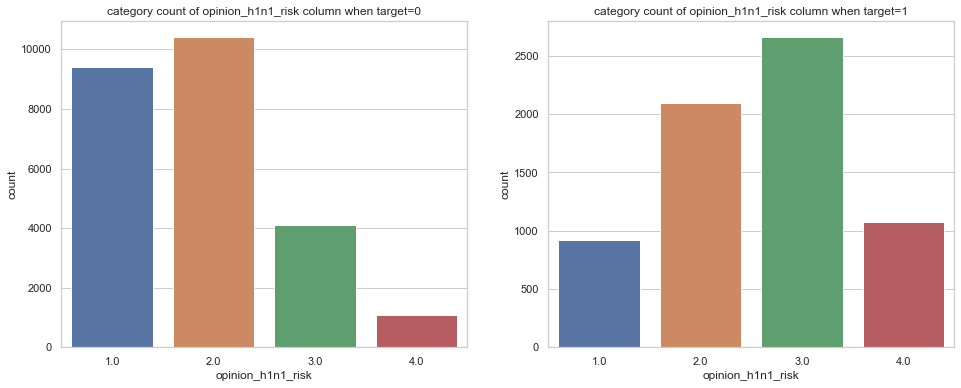

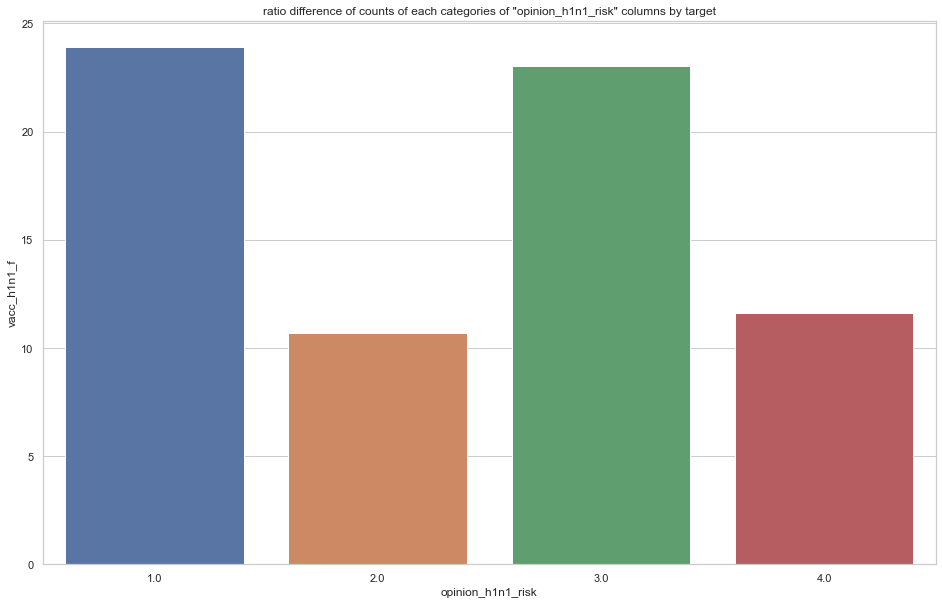

In [759]:
rdplot(df,'opinion_h1n1_risk')

##### opinion_h1n1_sick_from_vacc

- Description : Respondent's worry of getting sick from taking H1N1 vaccine.   

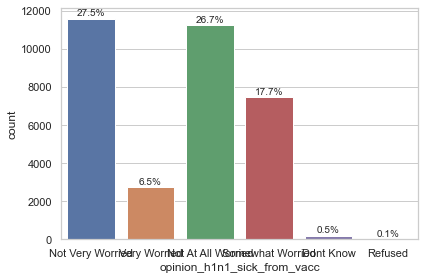

In [760]:
EDA_plot1(df,'opinion_h1n1_sick_from_vacc')

- Note : ordered categorical type, Don't Know/Refused -> nan

In [761]:
df['opinion_h1n1_sick_from_vacc'].replace('Dont Know',np.nan,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Refused',np.nan,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Not At All Worried',0,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Not Very Worried',1,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Somewhat Worried',2,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Very Worried',3,inplace=True)

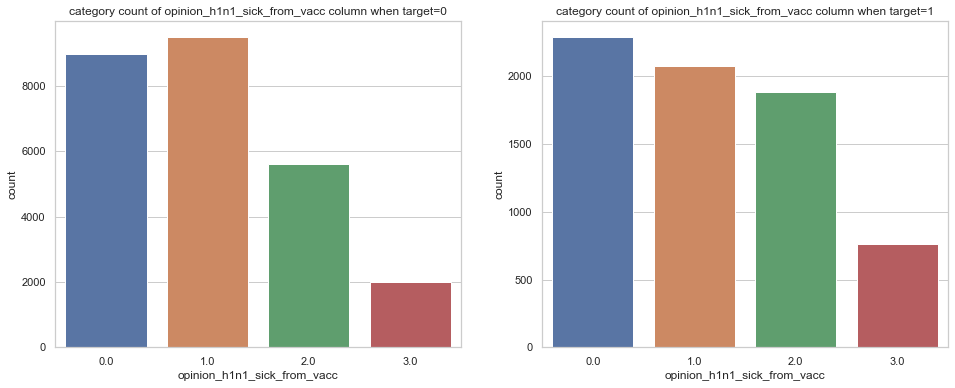

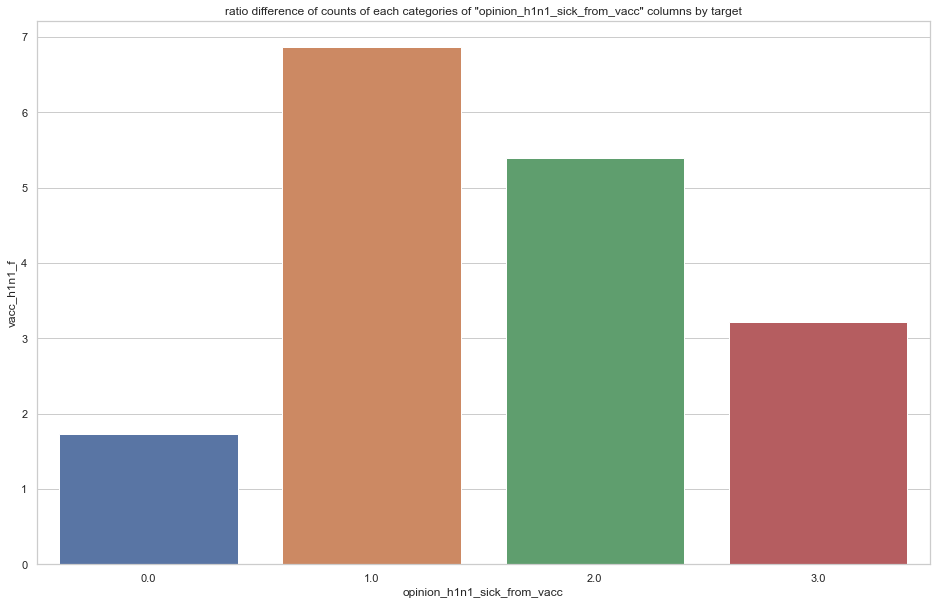

In [762]:
rdplot(df,'opinion_h1n1_sick_from_vacc')

##### opinion_seas_vacc_effective

- Description : Respondent's opinion about seasonal flu vaccine effectiveness.   

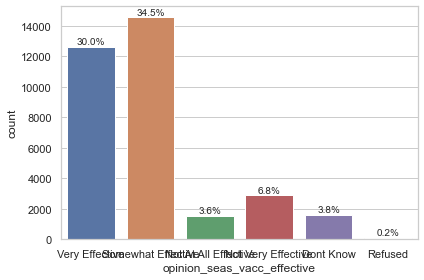

In [763]:
EDA_plot1(df,'opinion_seas_vacc_effective')

- Note : ordered categorical type, Don't Know/Refused -> nan

In [764]:
df['opinion_seas_vacc_effective'].replace('Dont Know',np.nan,inplace=True)
df['opinion_seas_vacc_effective'].replace('Refused',np.nan,inplace=True)
df['opinion_seas_vacc_effective'].replace('Not At All Effective',0,inplace=True)
df['opinion_seas_vacc_effective'].replace('Not Very Effective',1,inplace=True)
df['opinion_seas_vacc_effective'].replace('Somewhat Effective',2,inplace=True)
df['opinion_seas_vacc_effective'].replace('Very Effective',3,inplace=True)

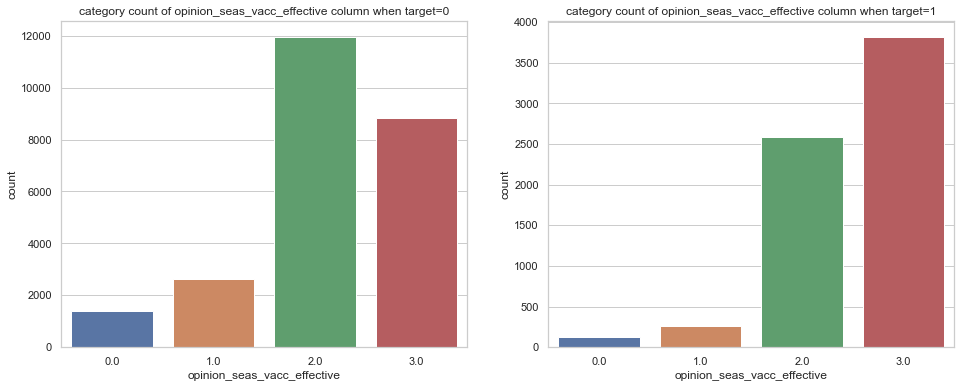

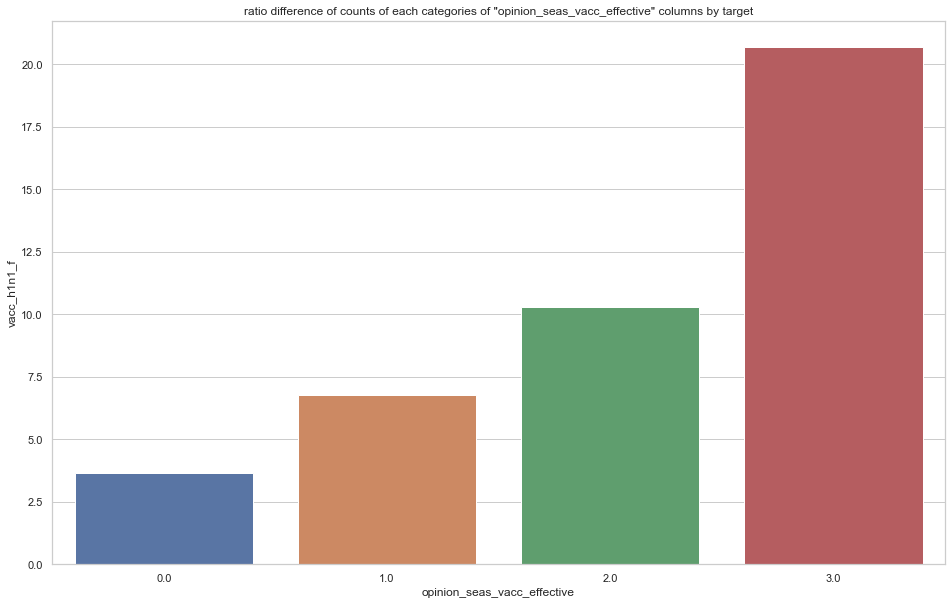

In [765]:
rdplot(df,'opinion_seas_vacc_effective')

##### opinion_seas_risk

- Description : Respondent's opinion about risk of getting sick with seasonal flu without vaccine.   

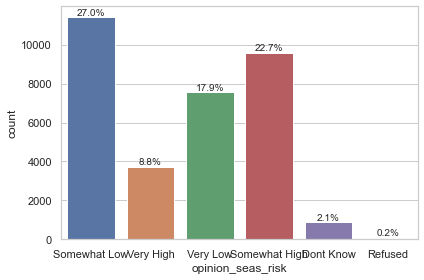

In [766]:
EDA_plot1(df,'opinion_seas_risk')

- Note : ordered categorical type, Don't Know/Refused -> nan, seasonal

In [767]:
df['opinion_seas_risk'].replace('Dont Know',np.nan,inplace=True)
df['opinion_seas_risk'].replace('Refused',np.nan,inplace=True)
df['opinion_seas_risk'].replace('Very Low',1,inplace=True)
df['opinion_seas_risk'].replace('Somewhat Low',2,inplace=True)
df['opinion_seas_risk'].replace('Somewhat High',3,inplace=True)
df['opinion_seas_risk'].replace('Very High',4,inplace=True)

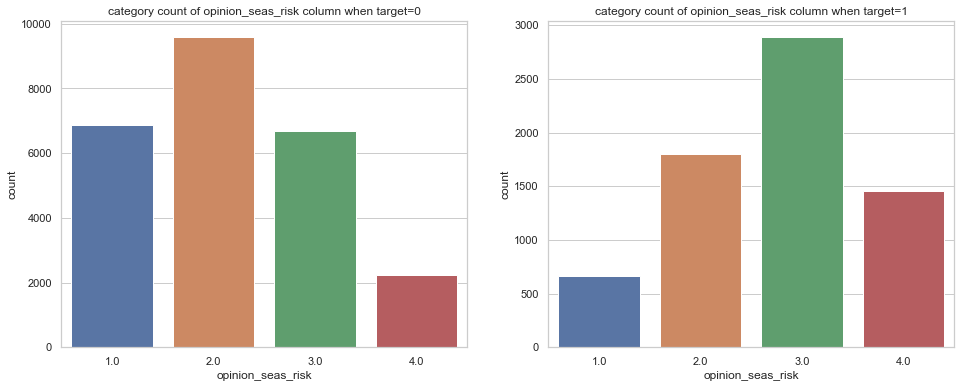

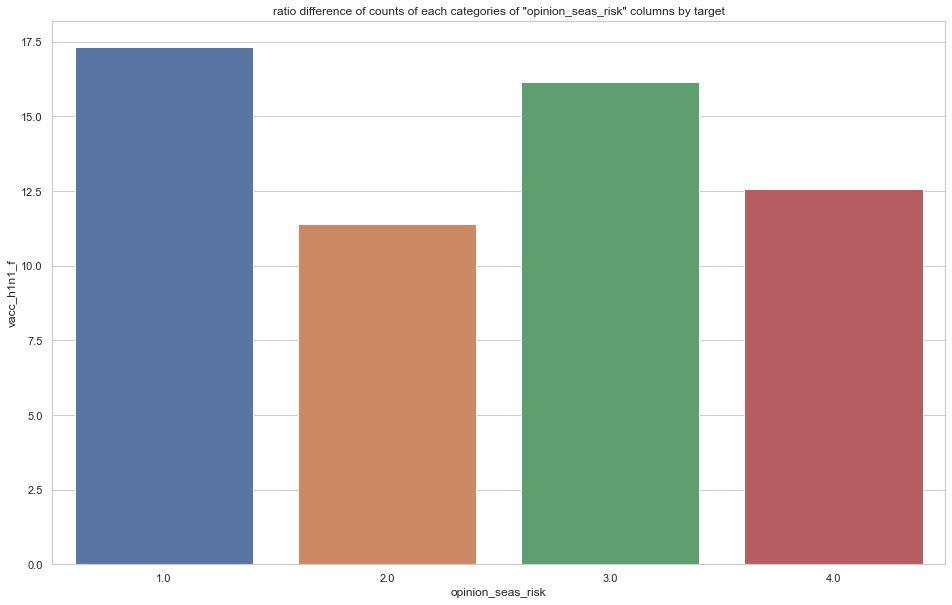

In [768]:
rdplot(df,'opinion_seas_risk')

##### opinion_seas_sick_from_vacc

- Description : Respondent's worry of getting sick from taking seasonal flu vaccine.  

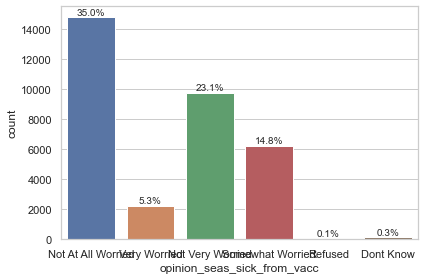

In [769]:
EDA_plot1(df,'opinion_seas_sick_from_vacc')

- Note : ordered categorical type, Don't Know/Refused -> nan, seasonal

In [770]:
df['opinion_seas_sick_from_vacc'].replace('Dont Know',np.nan,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Refused',np.nan,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Not At All Worried',0,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Not Very Worried',1,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Somewhat Worried',2,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Very Worried',3,inplace=True)

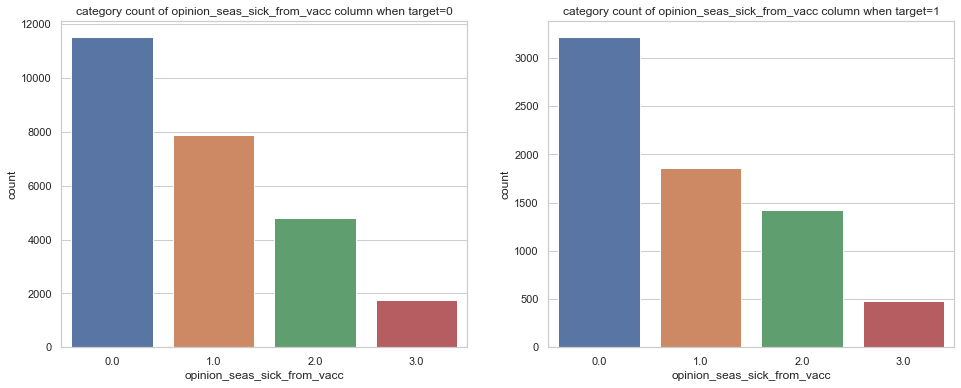

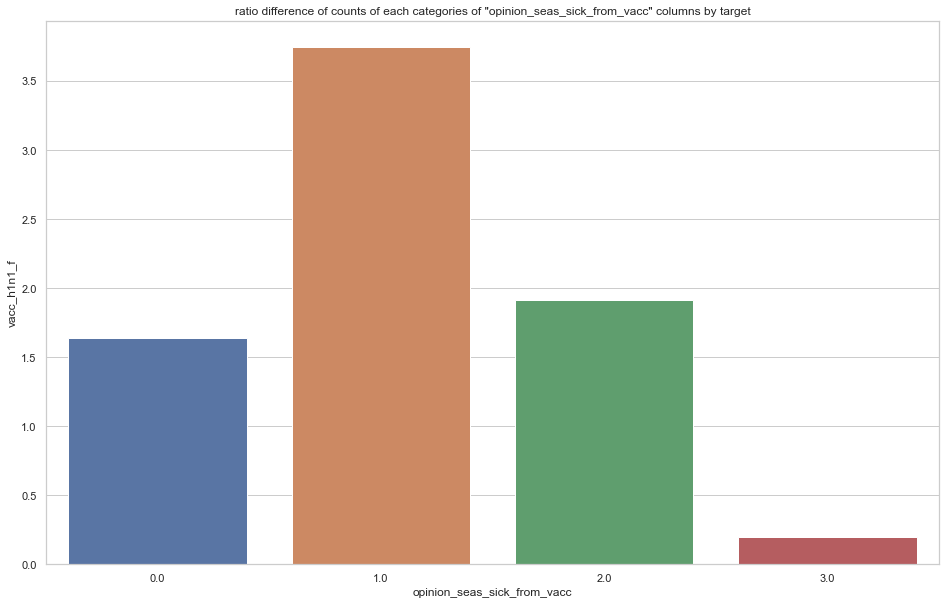

In [771]:
rdplot(df,'opinion_seas_sick_from_vacc')

##### agegrp

- Description : Age group of respondent.   

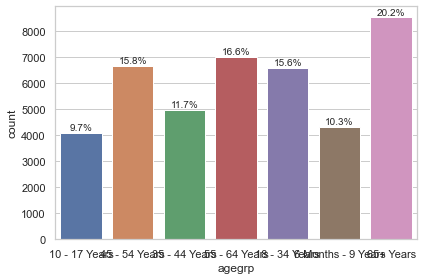

In [772]:
EDA_plot1(df,'agegrp')

- Note : ordered categorical type

In [773]:
df['agegrp'].replace('6 Months - 9 Years',1,inplace=True)
df['agegrp'].replace('10 - 17 Years',2,inplace=True)
df['agegrp'].replace('18 - 34 Years',3,inplace=True)
df['agegrp'].replace('35 - 44 Years',4,inplace=True)
df['agegrp'].replace('45 - 54 Years',5,inplace=True)
df['agegrp'].replace('55 - 64 Years',6,inplace=True)
df['agegrp'].replace('65+ Years',7,inplace=True)

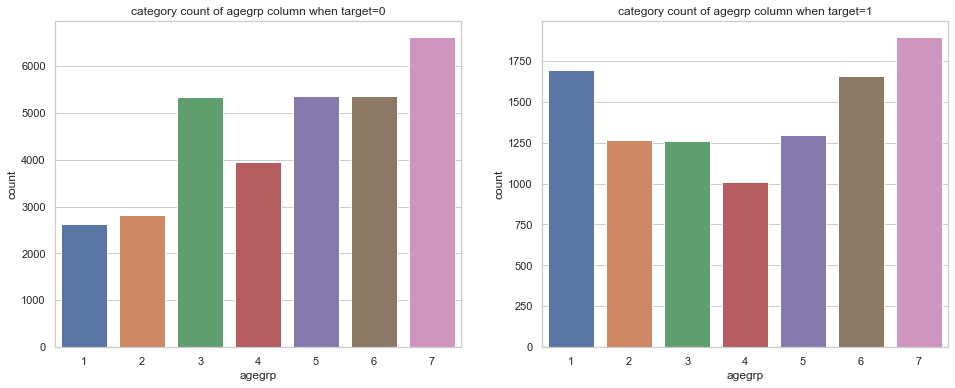

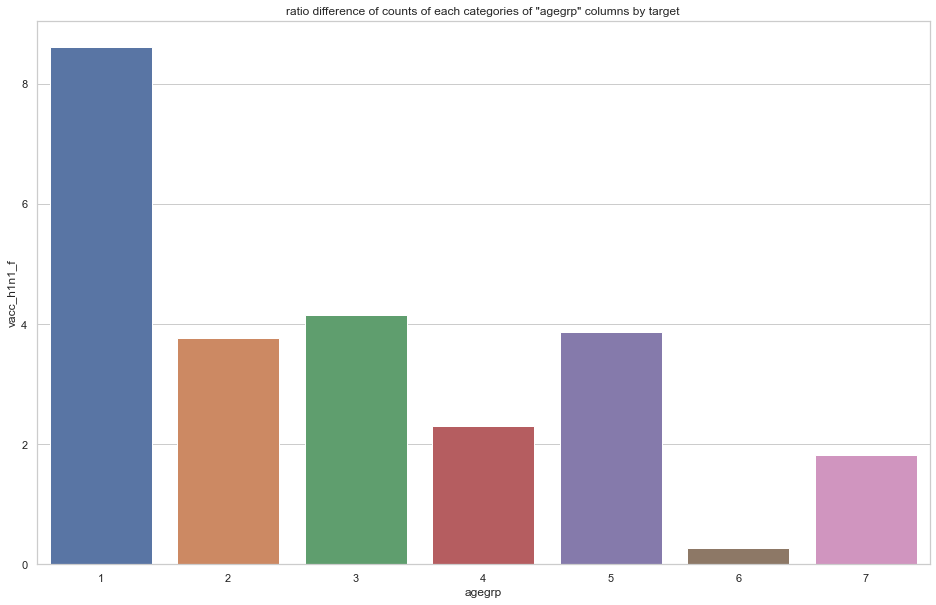

In [774]:
rdplot(df,'agegrp')

##### education_comp

- Description : Self-reported education level.   
1 = < 12 Years; 2 = 12 Years; 3 = Some College; 4 = College Graduate   

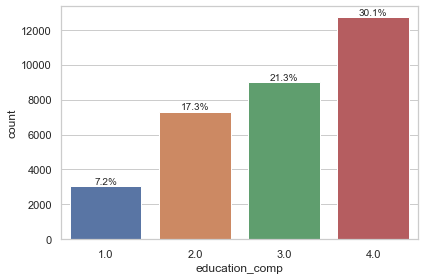

In [775]:
EDA_plot1(df,'education_comp')

- Note : ordered categorical type, corr with agegrp

In [776]:
# agegrp 별 밸류카운트

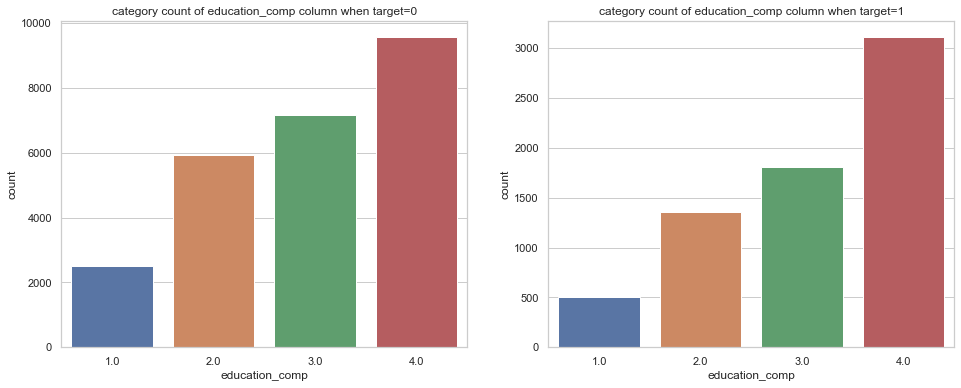

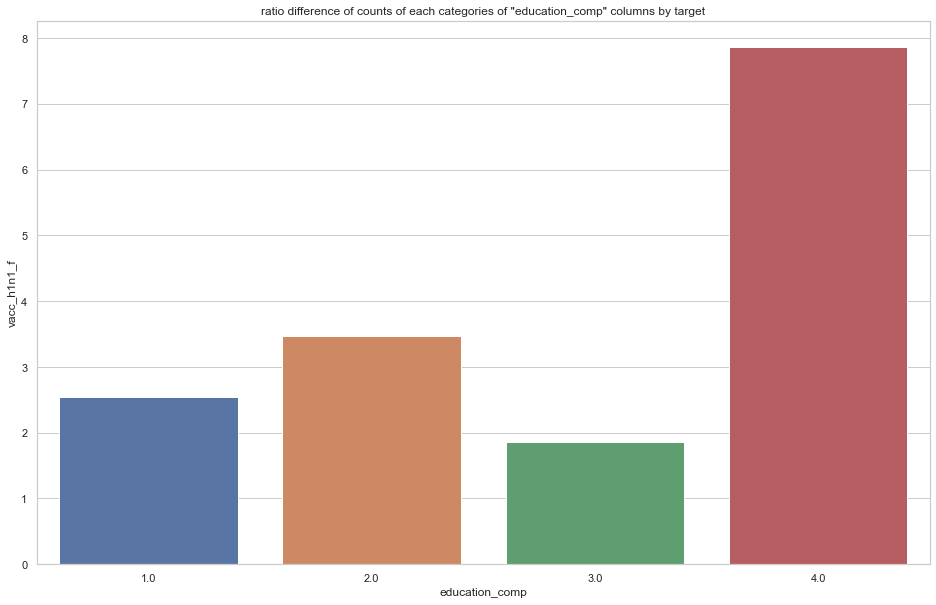

In [777]:
rdplot(df,'education_comp')

##### raceeth4_i

- Description : Race of respondent.   
1 = Hispanic; 2 = Non-Hispanic, Black Only; 3 = Non-Hispanic, White Only; 4 = Non-Hispanic, Other or Multiple Races   

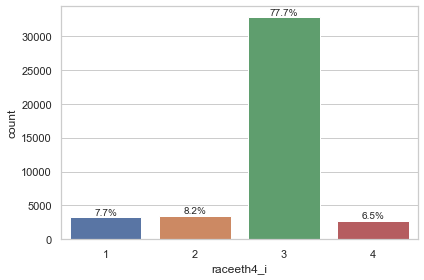

In [778]:
EDA_plot1(df,'raceeth4_i')

- Note : categorical type

In [779]:
df['raceeth4_i'].replace(1,'Hispanic',inplace=True)
df['raceeth4_i'].replace(2,'Non-Hispanic, Black Only',inplace=True)
df['raceeth4_i'].replace(3,'Non-Hispanic, White Only',inplace=True)
df['raceeth4_i'].replace(4,'Non-Hispanic, Other or Multiple Races ',inplace=True)
categorical_encoding_needed.append('raceeth4_i')

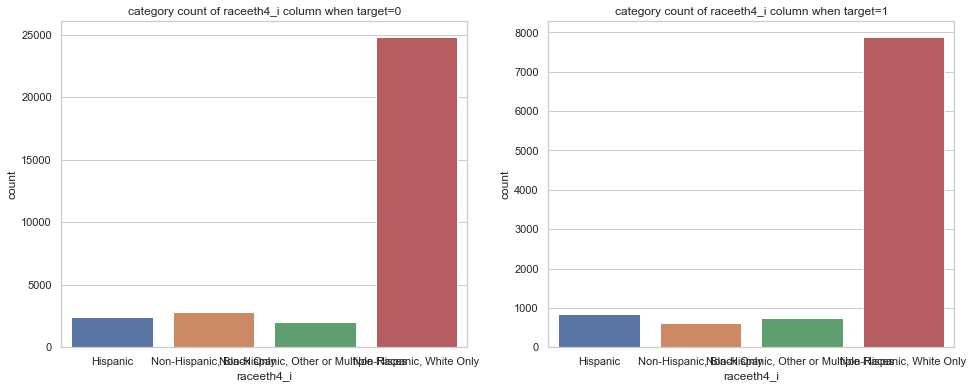

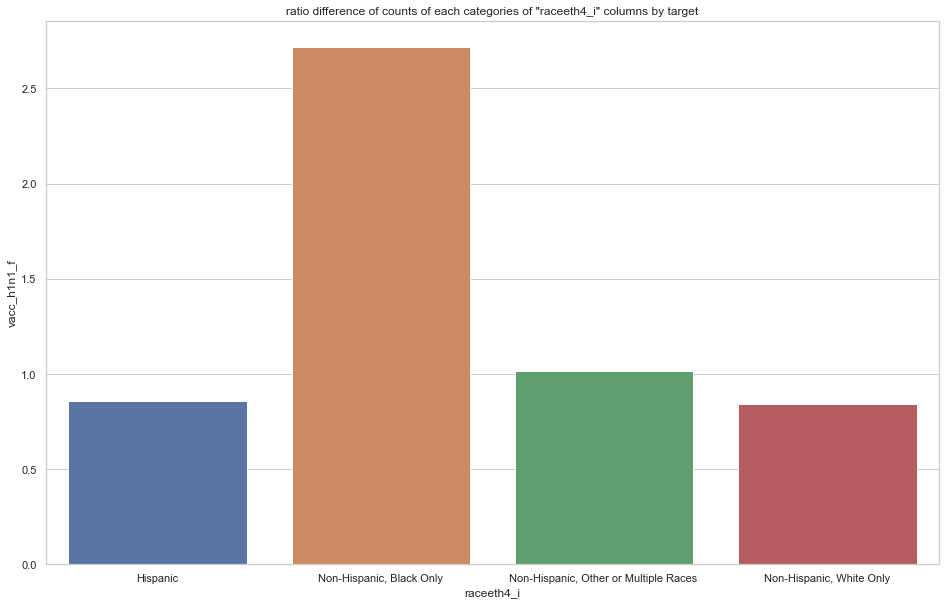

In [780]:
rdplot(df,'raceeth4_i')

##### sex_i

- Description : Sex of respondent.   
1 = Male; 2 = Female   

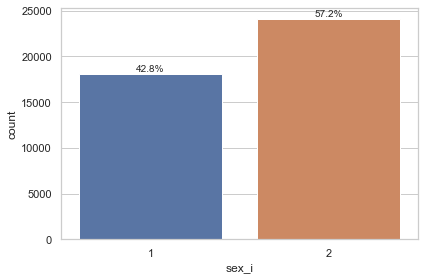

In [781]:
EDA_plot1(df,'sex_i')

- Note : boolean, Male=True, Female=False

In [782]:
df['sex_i'].replace(1,True,inplace=True)
df['sex_i'].replace(2,False,inplace=True)

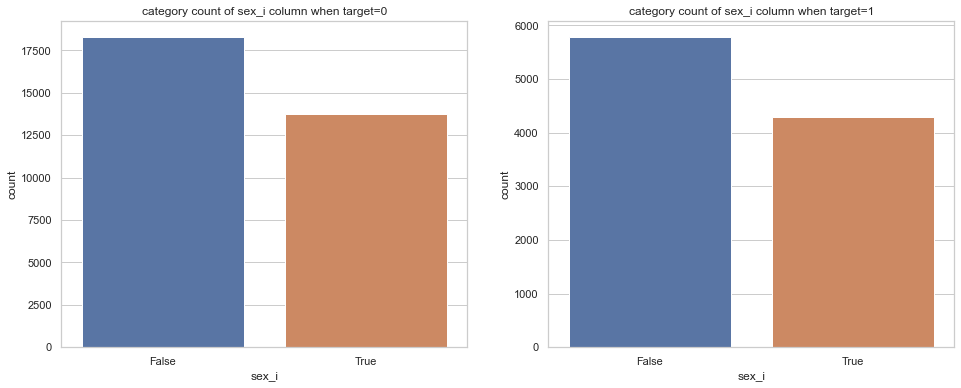

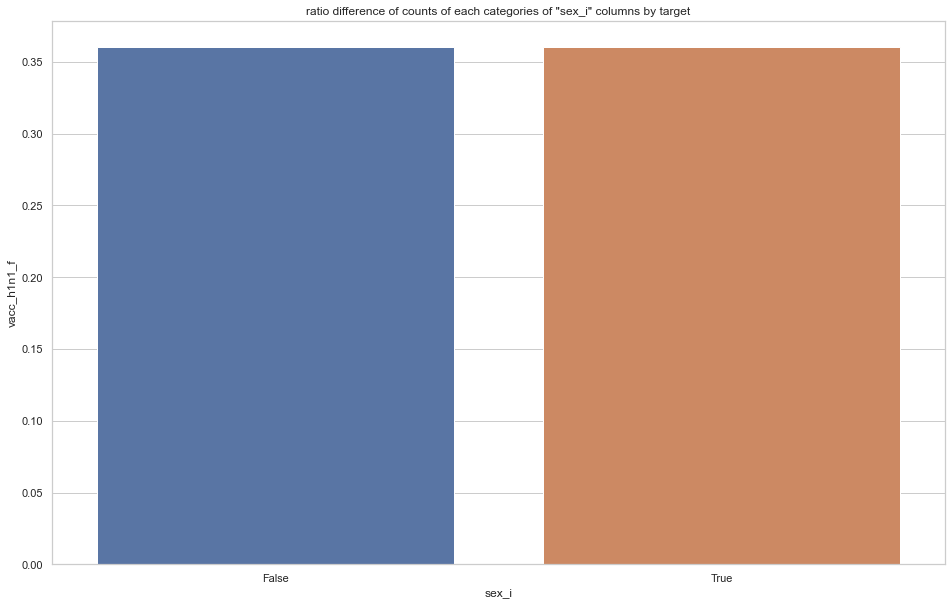

In [783]:
rdplot(df,'sex_i')

##### inc_pov

- Description : Household annual income of respondent with respect to 2008 Census poverty thresholds.   
1 = > $75,000; 2 = <= $75,000; 3 = Below Poverty; 4 = Unknown   

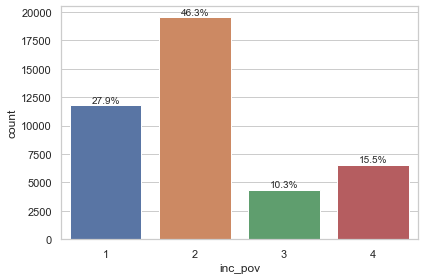

In [784]:
EDA_plot1(df,'inc_pov')

- Note : ordered categorical type, 4(Unknown) -> np.nan, 3(Below Poverty) -> 1, 1(>=$7500) -> 3

In [785]:
df['inc_pov'].replace(4,np.nan,inplace=True)
df['inc_pov'].replace(3,5,inplace=True)
df['inc_pov'].replace(1,3,inplace=True)
df['inc_pov'].replace(5,1,inplace=True)

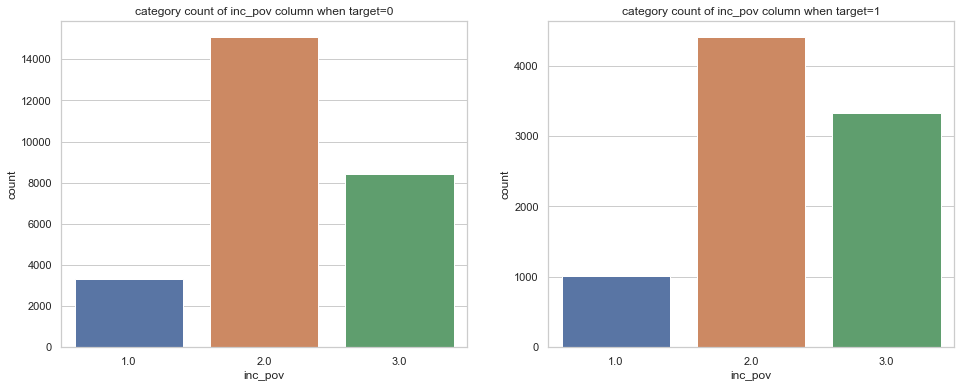

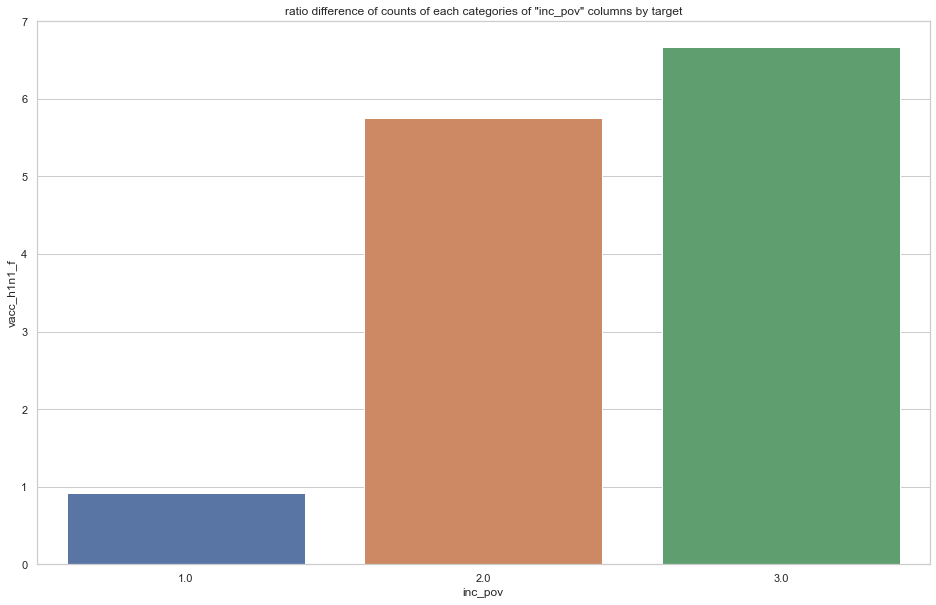

In [786]:
rdplot(df,'inc_pov')

##### marital

- Description : Marital status of respondent.   
1 = Married; 2 = Not Married   

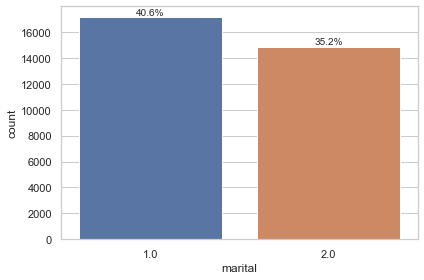

In [787]:
EDA_plot1(df,'marital')

- Note : boolean

In [788]:
df['marital'].replace(1,True,inplace=True)
df['marital'].replace(2,False,inplace=True)

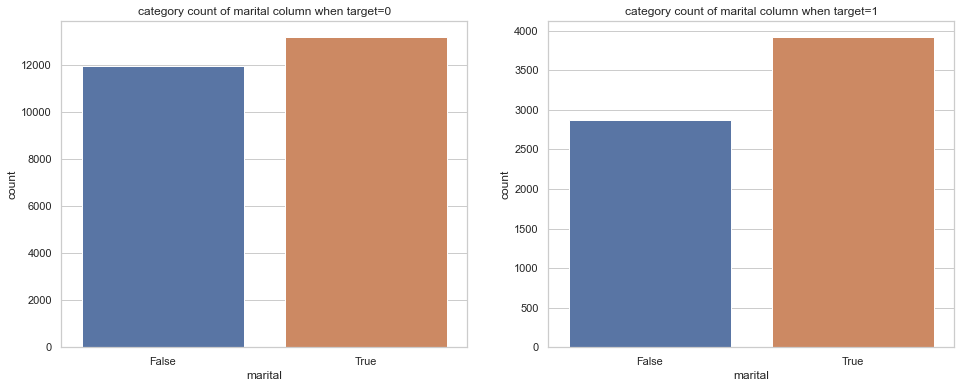

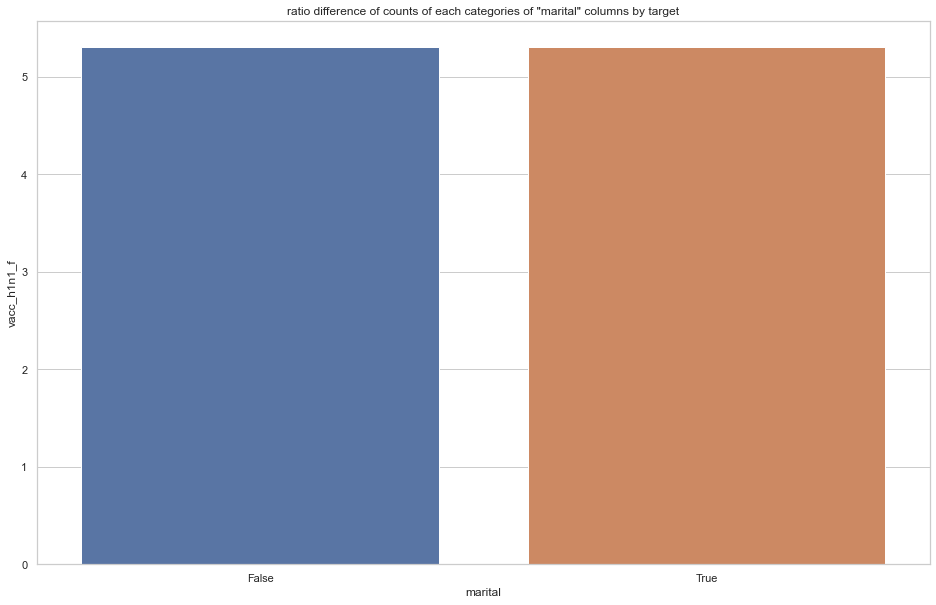

In [789]:
rdplot(df,'marital')

##### rent_own_r

- Description : Housing situation of respondent.   
1 = Home is Owned; 2 = Home is Rented or Other Arrangement   

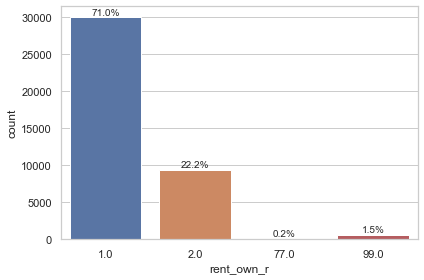

In [790]:
EDA_plot1(df,'rent_own_r')

- Note : boolean, Outliers(77,99 -> np.nan)

In [791]:
df['rent_own_r'].replace(77,np.nan,inplace=True)
df['rent_own_r'].replace(99,np.nan,inplace=True)
df['rent_own_r'].replace(1,True,inplace=True)
df['rent_own_r'].replace(2,False,inplace=True)

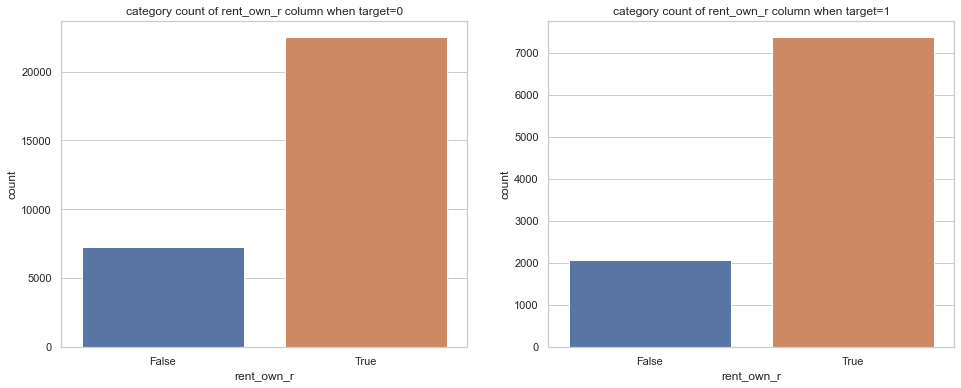

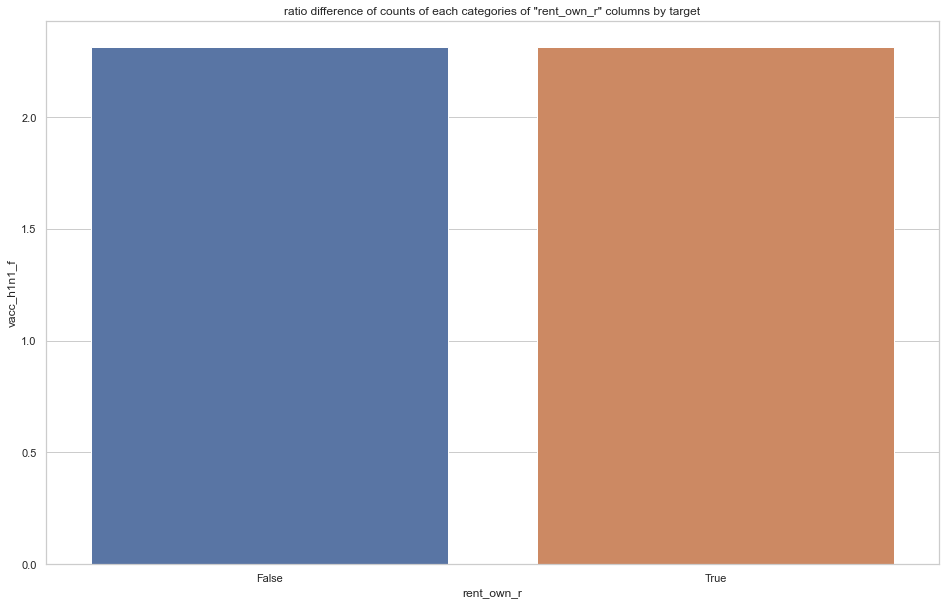

In [792]:
rdplot(df,'rent_own_r')

##### employment_status

- Description : Employment status of respondent.   

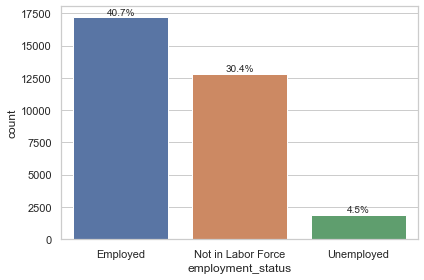

In [793]:
EDA_plot1(df,'employment_status')

- Note : ordered categorical type

In [794]:
df['employment_status'].replace('Unemployed',0,inplace=True)
df['employment_status'].replace('Not in Labor Force',1,inplace=True)
df['employment_status'].replace('Employed',2,inplace=True)

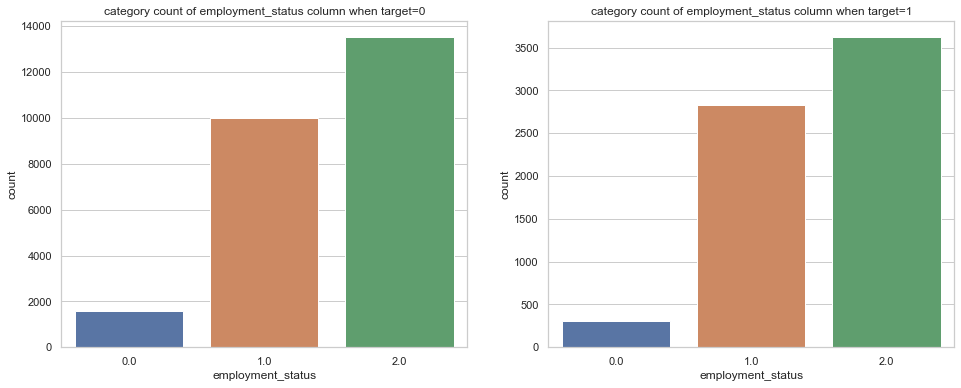

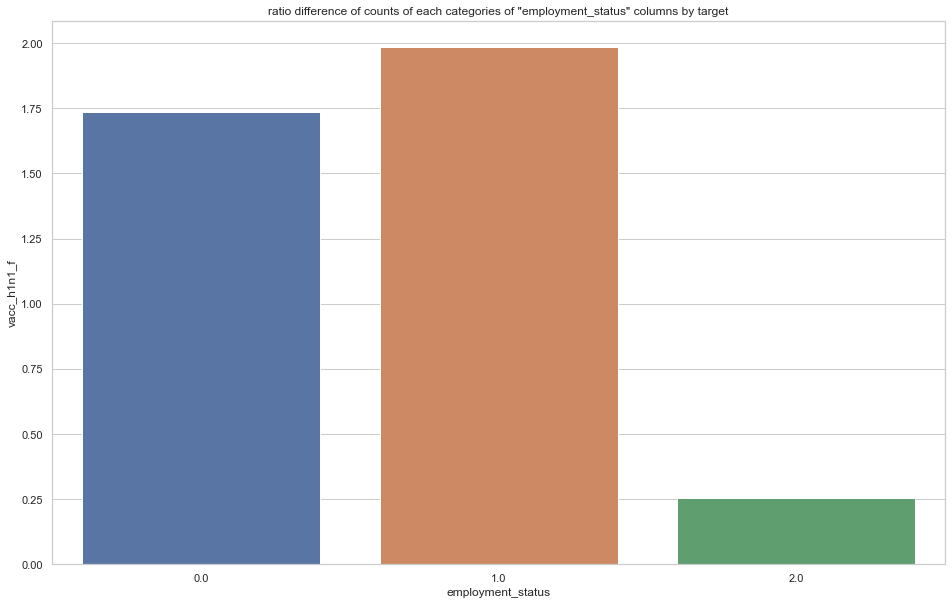

In [795]:
rdplot(df,'employment_status')

##### census_region

- Description : True census region of residence   
1=northeast; 2=midwest; 3=south; 4=west   

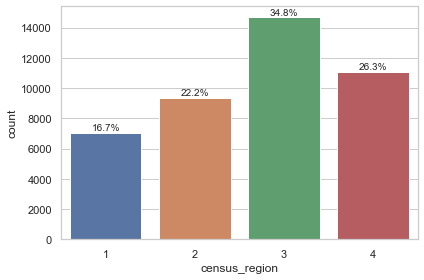

In [796]:
EDA_plot1(df,'census_region')

- Note : categorical type, location information

In [797]:
df['census_region'].replace(1,'northeast',inplace=True)
df['census_region'].replace(2,'midwest',inplace=True)
df['census_region'].replace(3,'south',inplace=True)
df['census_region'].replace(4,'west',inplace=True)
categorical_encoding_needed.append('census_region')

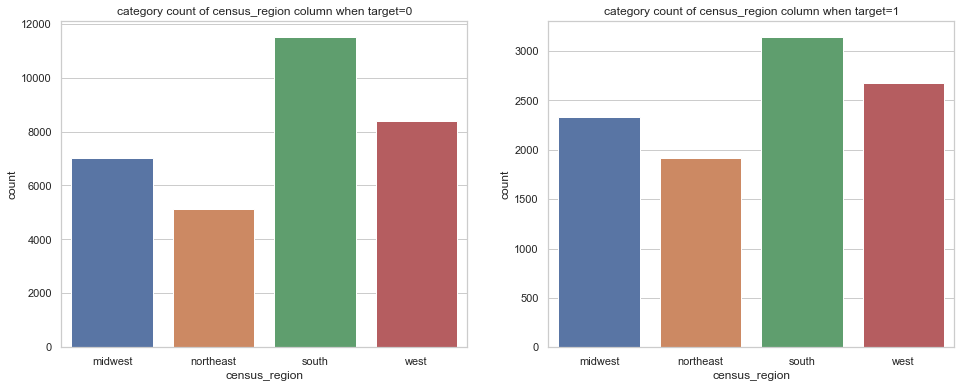

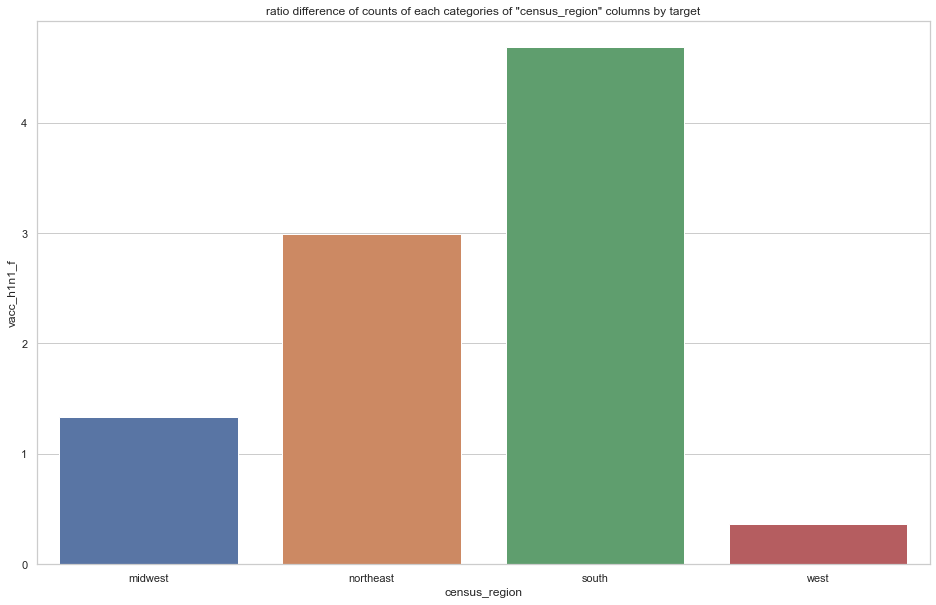

In [798]:
rdplot(df,'census_region')

##### census_msa

- Description : Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.   

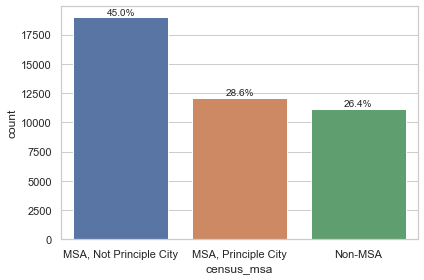

In [799]:
EDA_plot1(df,'census_msa')

- Note : ordered categorical type, location information

In [800]:
df['census_msa'].replace('Non-MSA',0,inplace=True)
df['census_msa'].replace('MSA, Not Principle City',1,inplace=True)
df['census_msa'].replace('MSA, Principle City',2,inplace=True)

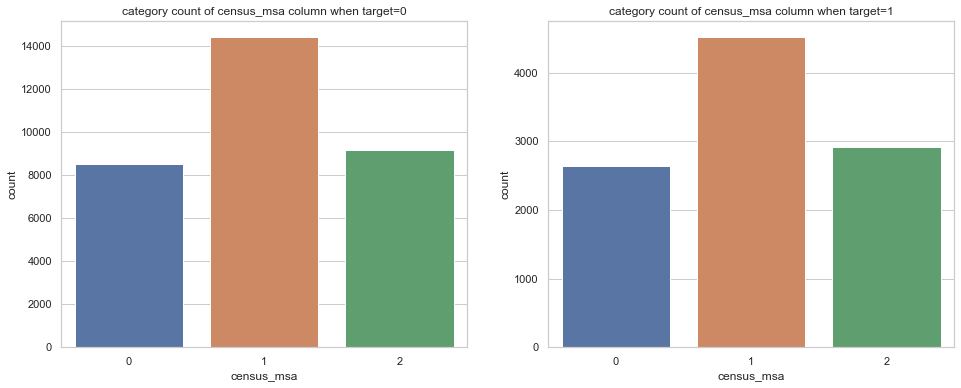

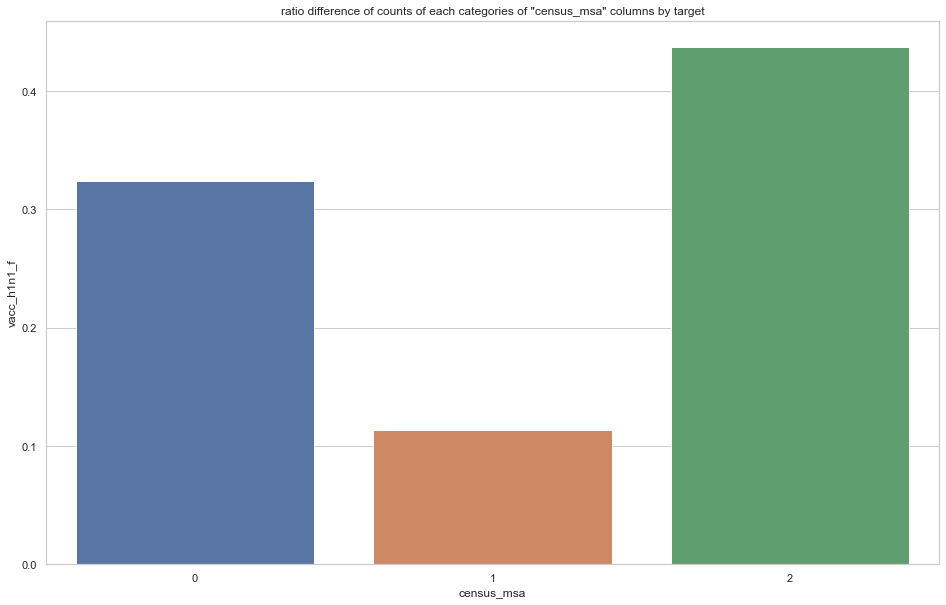

In [801]:
rdplot(df,'census_msa')

##### n_adult_r

- Description : Number of other adults in household.   

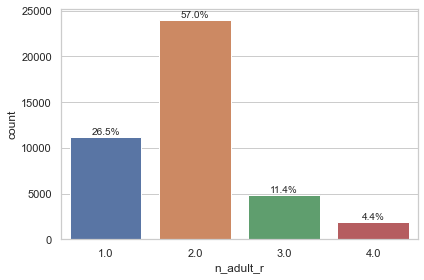

In [802]:
EDA_plot1(df,'n_adult_r')

- Note : ordered categorical type, corr with n_people_r

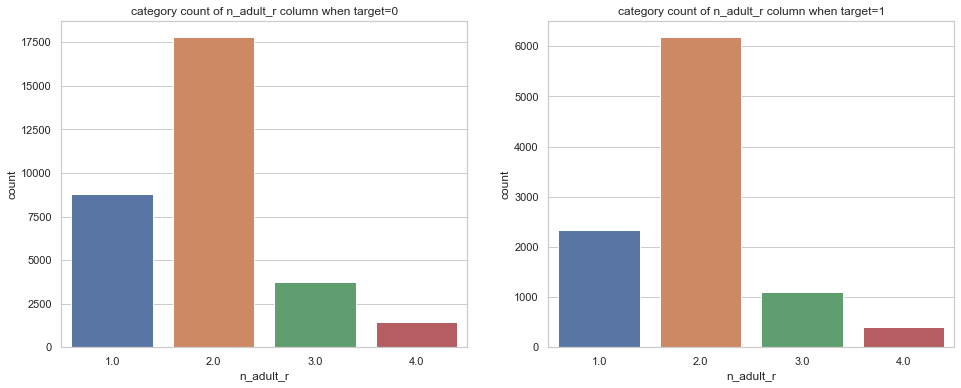

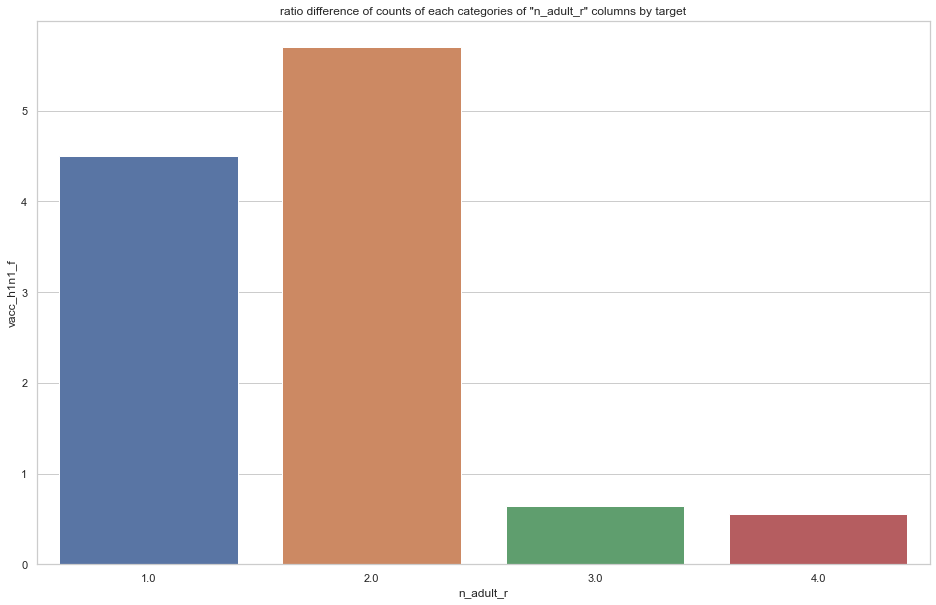

In [803]:
rdplot(df,'n_adult_r')

##### household_children

- Description : Number of children in household.   

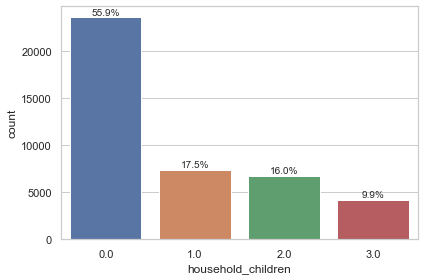

In [804]:
EDA_plot1(df,'household_children')

- Note : ordered categorical type, corr with n_people_r

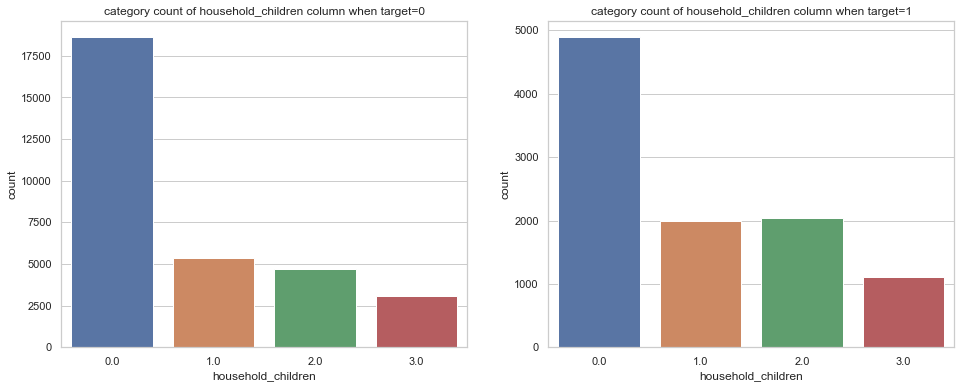

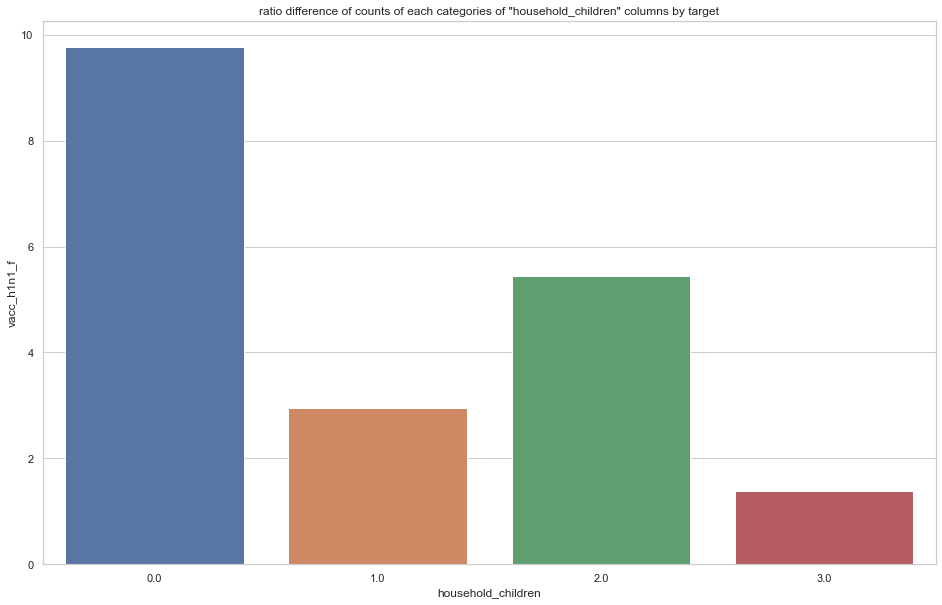

In [805]:
rdplot(df,'household_children')

##### n_people_r

- Description : Number of adults in the household.   

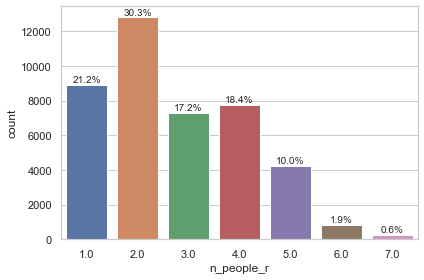

In [806]:
EDA_plot1(df,'n_people_r')

- Note : ordered categorical type, corr with n_adult_r and household_children

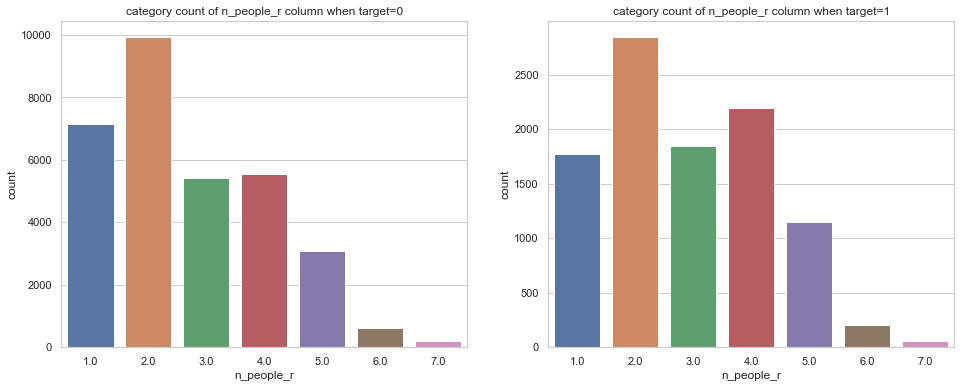

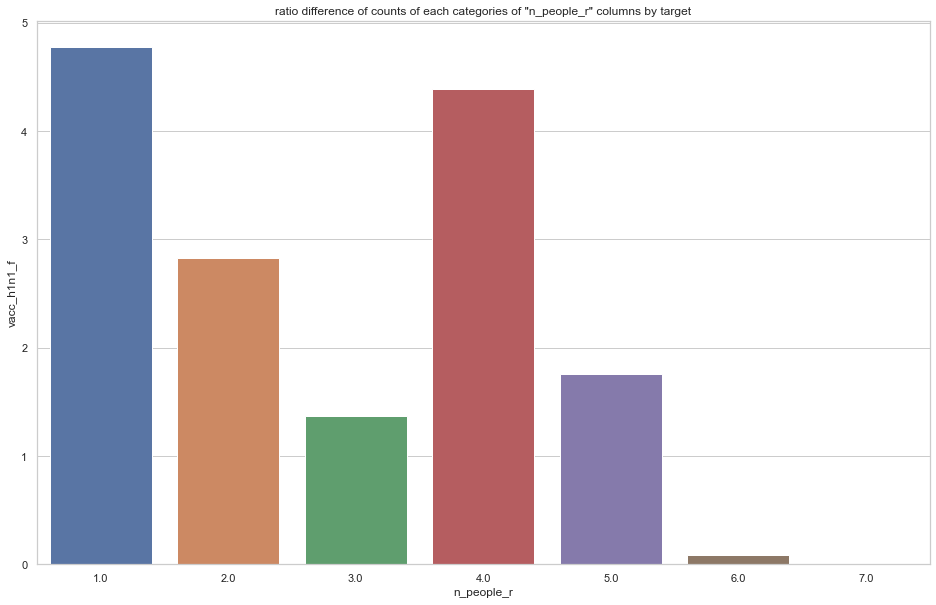

In [807]:
rdplot(df,'n_people_r')

##### employment_industry

- Description : Type of industry respondent is employed in.   

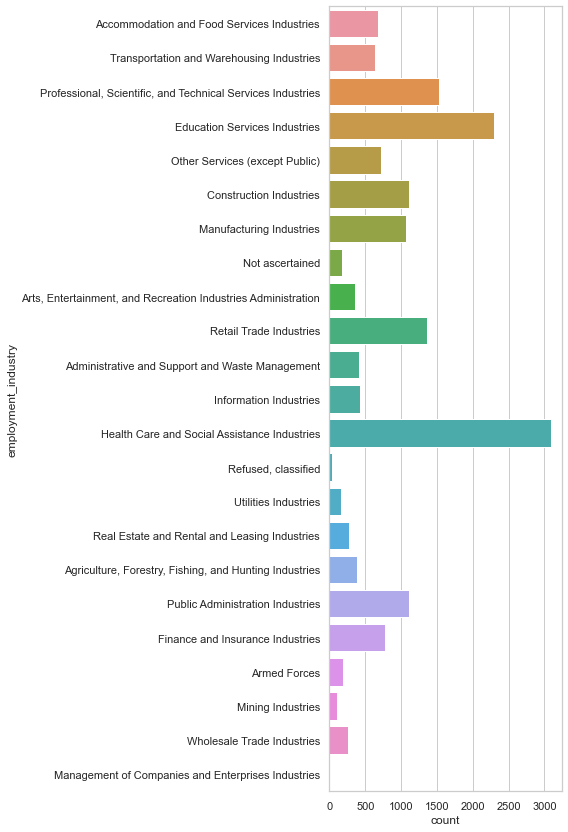

In [808]:
EDA_plot1(df,'employment_industry')

- Note : categorical type, Refused/classified -> np.nan, high cardinality, corr with employment_status and employment_occupation

In [809]:
df['employment_industry'].replace('Refused, classified',np.nan,inplace=True)
df['employment_industry'].replace('Not ascertained',np.nan,inplace=True)
categorical_encoding_needed.append('employment_industry')

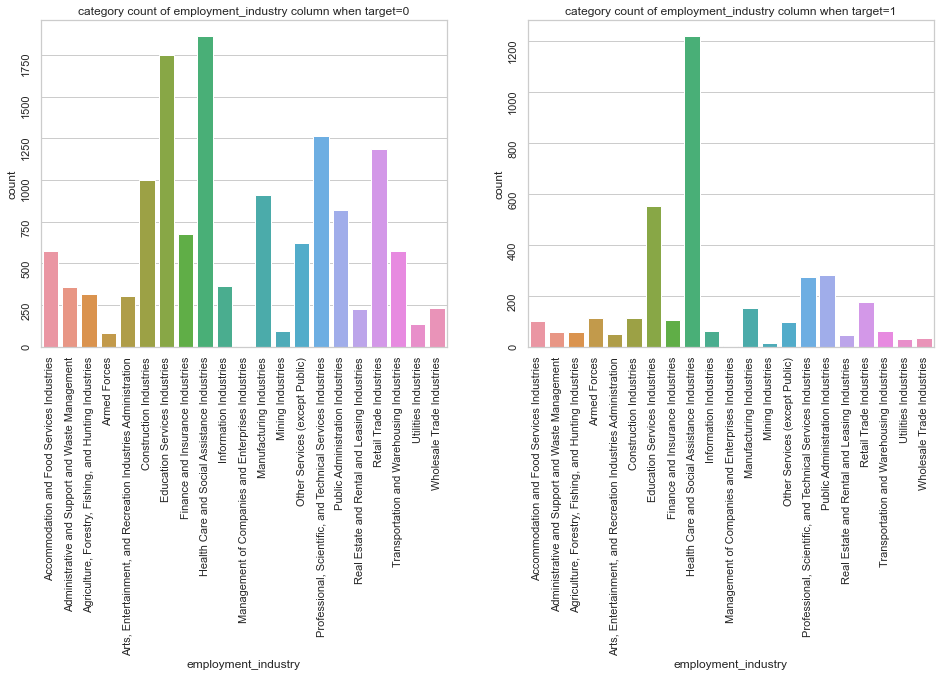

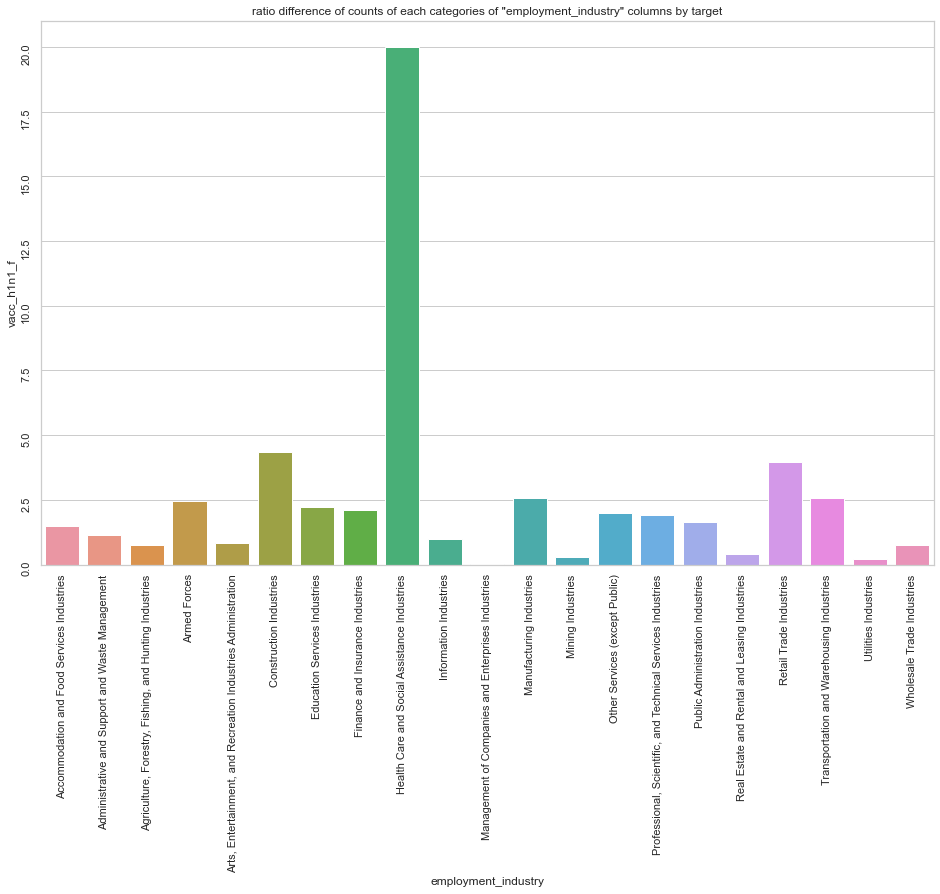

In [810]:
rdplot(df,'employment_industry',rot=90)

##### employment_occupation

- Description : Type of occupation of respondent. Values are represented as short random character strings.   

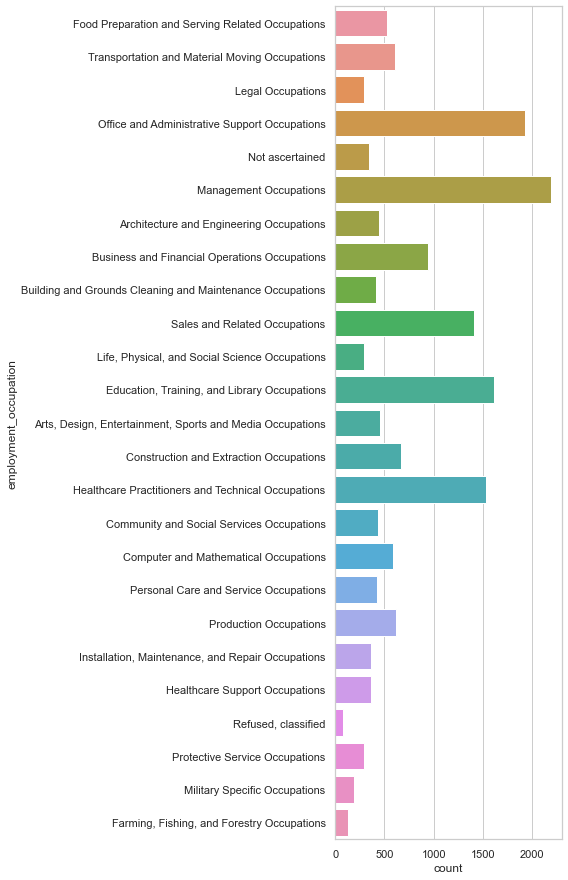

In [811]:
EDA_plot1(df,'employment_occupation')

- Note : categorical type, Refused/classified -> np.nan, high cardinality, corr with employment_status and employment_industry

In [812]:
print(df['employment_occupation'].unique())
print(df['employment_occupation'].describe())
df['employment_occupation'].replace('Refused, classified',np.nan,inplace=True)
df['employment_occupation'].replace('Not ascertained',np.nan,inplace=True)
print(df['employment_occupation'].unique())
print(df['employment_occupation'].describe())
categorical_encoding_needed.append('employment_occupation')

[nan 'Food Preparation and Serving Related Occupations'
 'Transportation and Material Moving Occupations' 'Legal Occupations'
 'Office and Administrative Support Occupations' 'Not ascertained'
 'Management Occupations' 'Architecture and Engineering Occupations'
 'Business and Financial Operations Occupations'
 'Building and Grounds Cleaning and Maintenance Occupations'
 'Sales and Related Occupations'
 'Life, Physical, and Social Science Occupations'
 'Education, Training, and Library Occupations'
 'Arts, Design, Entertainment, Sports and Media Occupations'
 'Construction and Extraction Occupations'
 'Healthcare Practitioners and Technical Occupations'
 'Community and Social Services Occupations'
 'Computer and Mathematical Occupations'
 'Personal Care and Service Occupations' 'Production Occupations'
 'Installation, Maintenance, and Repair Occupations'
 'Healthcare Support Occupations' 'Refused, classified'
 'Protective Service Occupations' 'Military Specific Occupations'
 'Farming, F

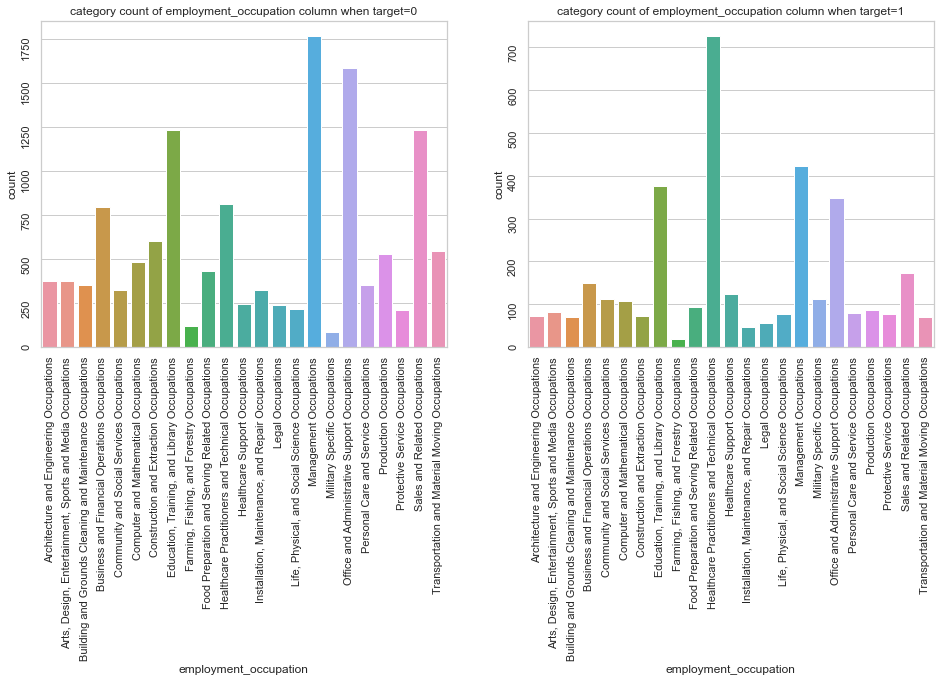

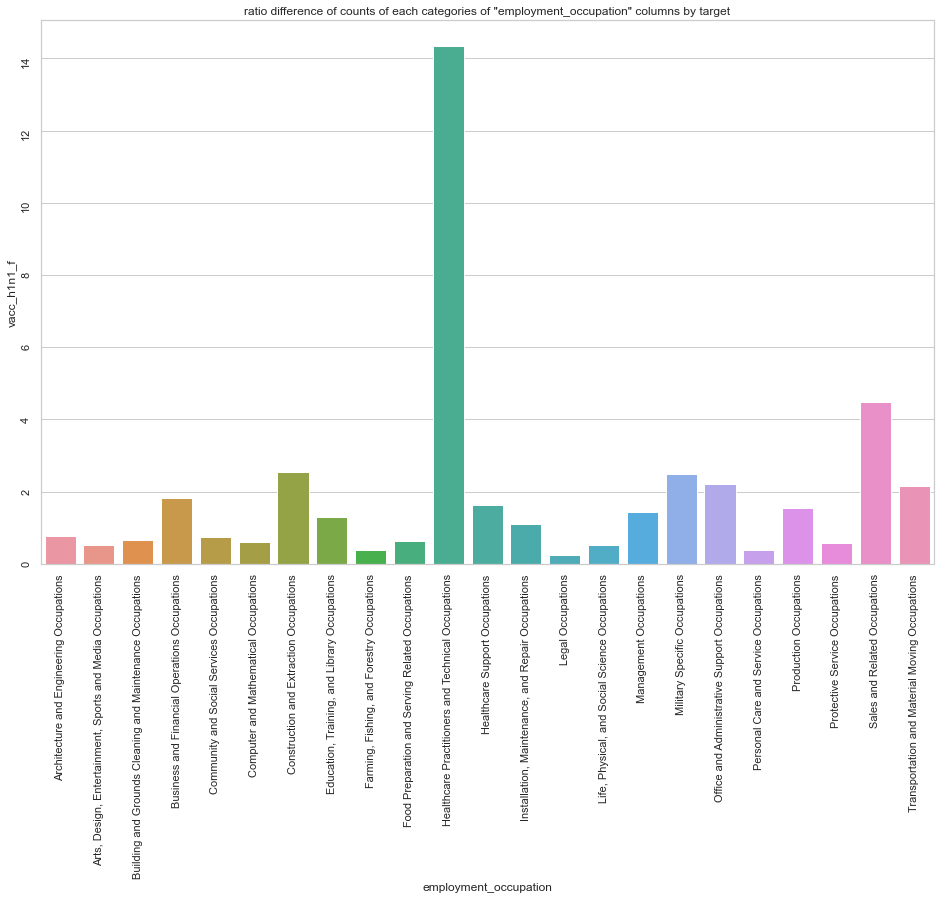

In [813]:
rdplot(df,'employment_occupation',rot=90)

##### hhs_region

- Description : HHS surveillance region number   
    - Region 1: CT,ME,MA,NH,RI,VT   
    - Region 2: NJ,NY   
    - Region 3: DE,DC,MD,PA,VA,WV   
    - Region 4: AL,FL,GA,KY,MS,NC,SC,TN   
    - Region 5: IL,IN,MI,MN,OH,WI   
    - Region 6: AR,LA,NM,OK,TX   
    - Region 7: IA,KS,MO,NE   
    - Region 8: CO,MT,ND,SD,UT,WY   
    - Region 9: AZ,CA,HI,NV   
    - Region 10: AK,ID,OR,WA   

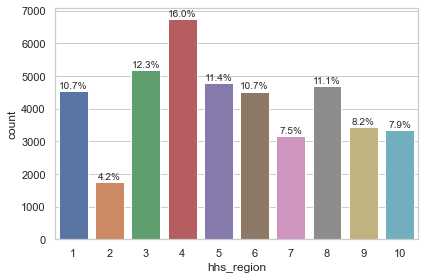

In [814]:
EDA_plot1(df,'hhs_region')

- Note : categorical type, location information, high cardinality

In [815]:
df['hhs_region']=df['hhs_region'].map(lambda x: 'Region'+str(x))
categorical_encoding_needed.append('hhs_region')

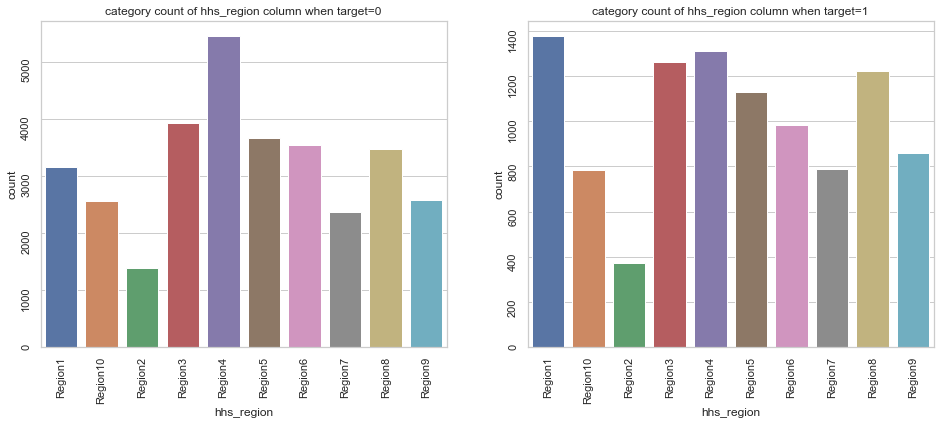

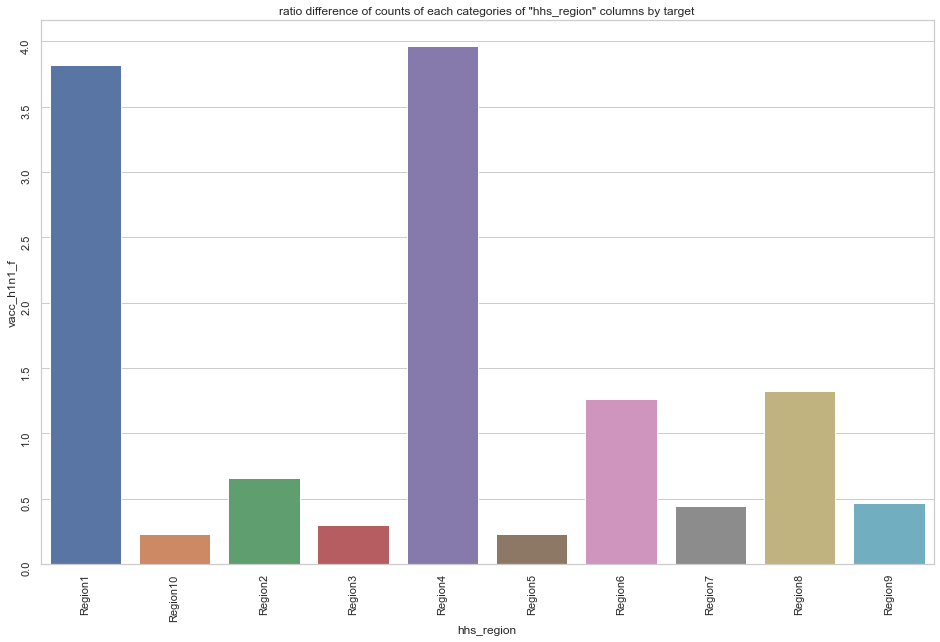

In [816]:
rdplot(df,'hhs_region',rot=90)

##### state

- Description : State of residence   

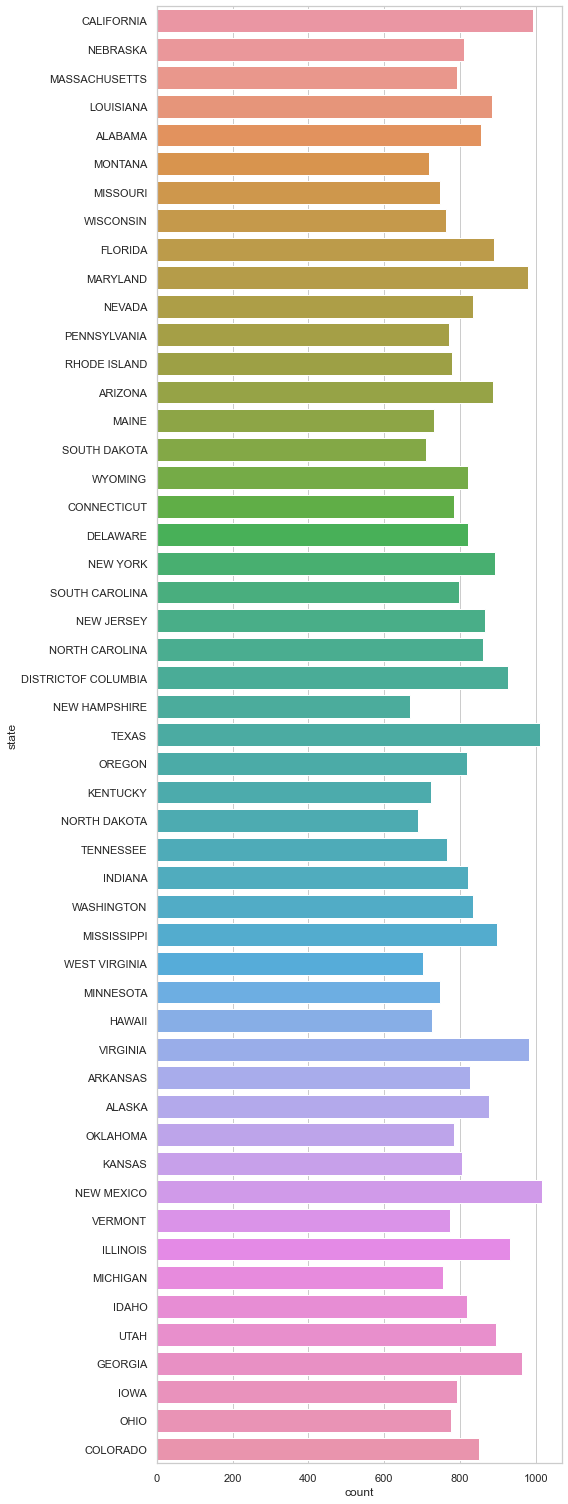

In [817]:
EDA_plot1(df,'state')

- Note : categorical type, local information, high cardinality

In [818]:

categorical_encoding_needed.append('state')

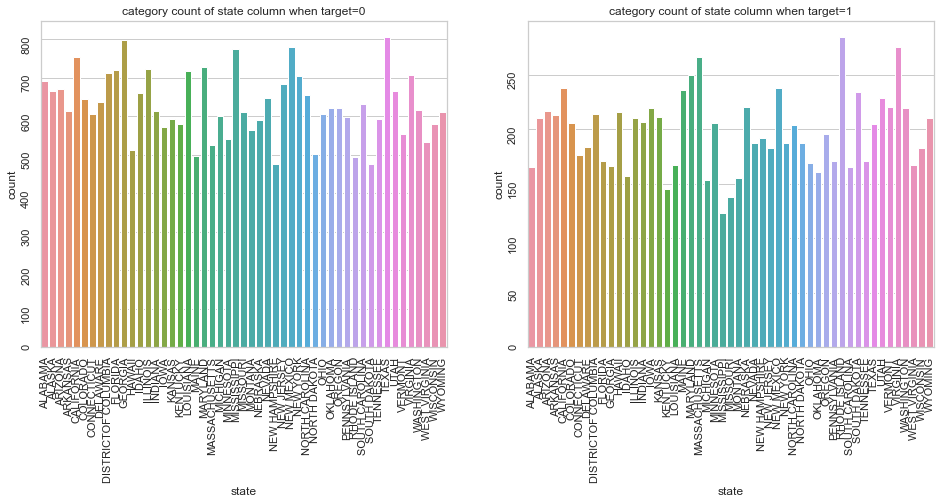

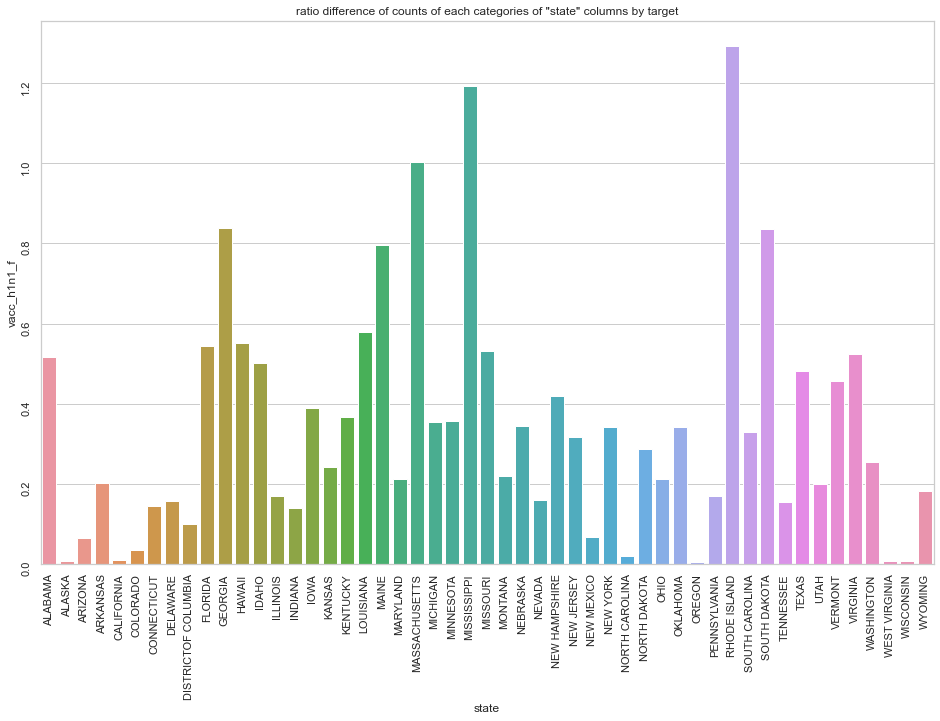

In [819]:
rdplot(df,'state',rot=90)

#### Multivariate analysis

##### Missing pattern and structurly missing data

<AxesSubplot:>

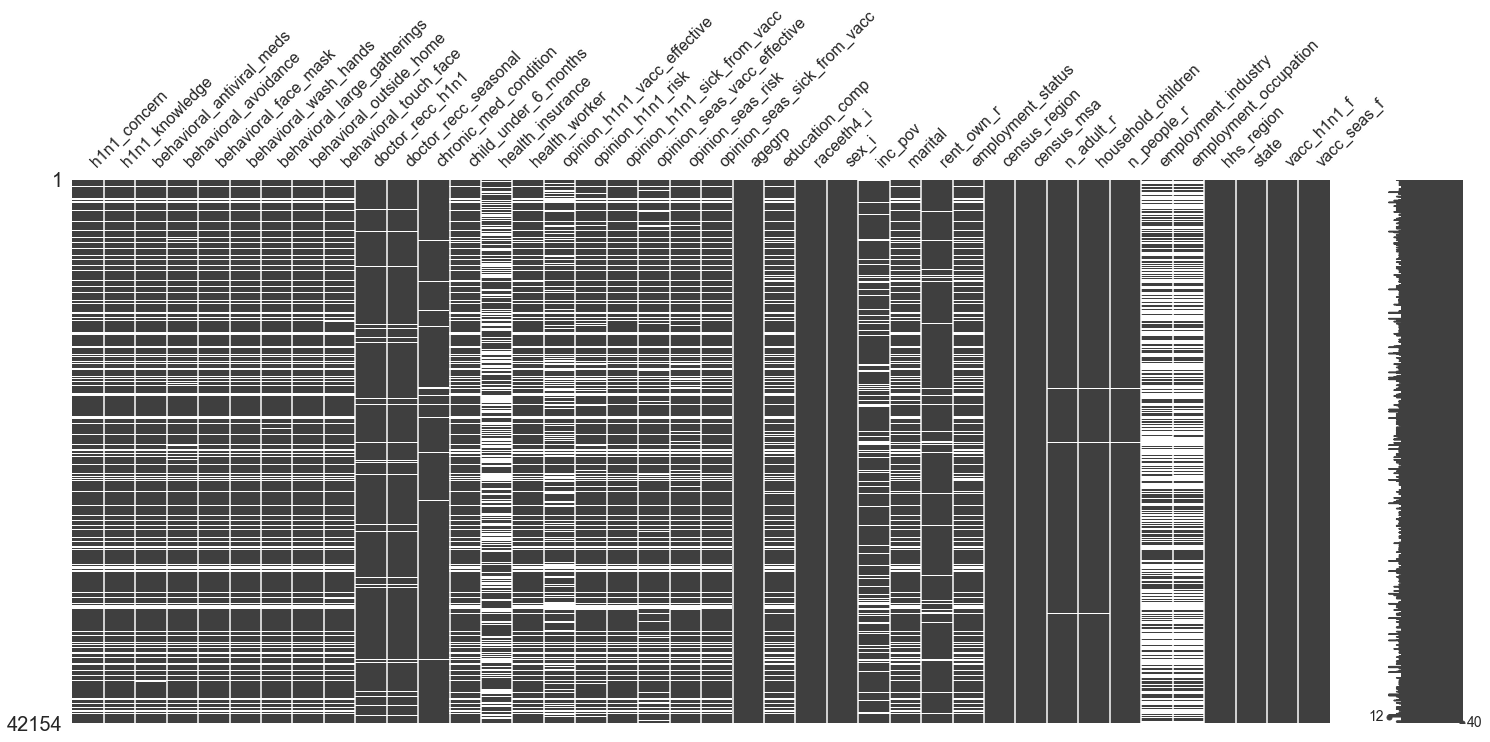

In [820]:
msno.matrix(df)

<AxesSubplot:>

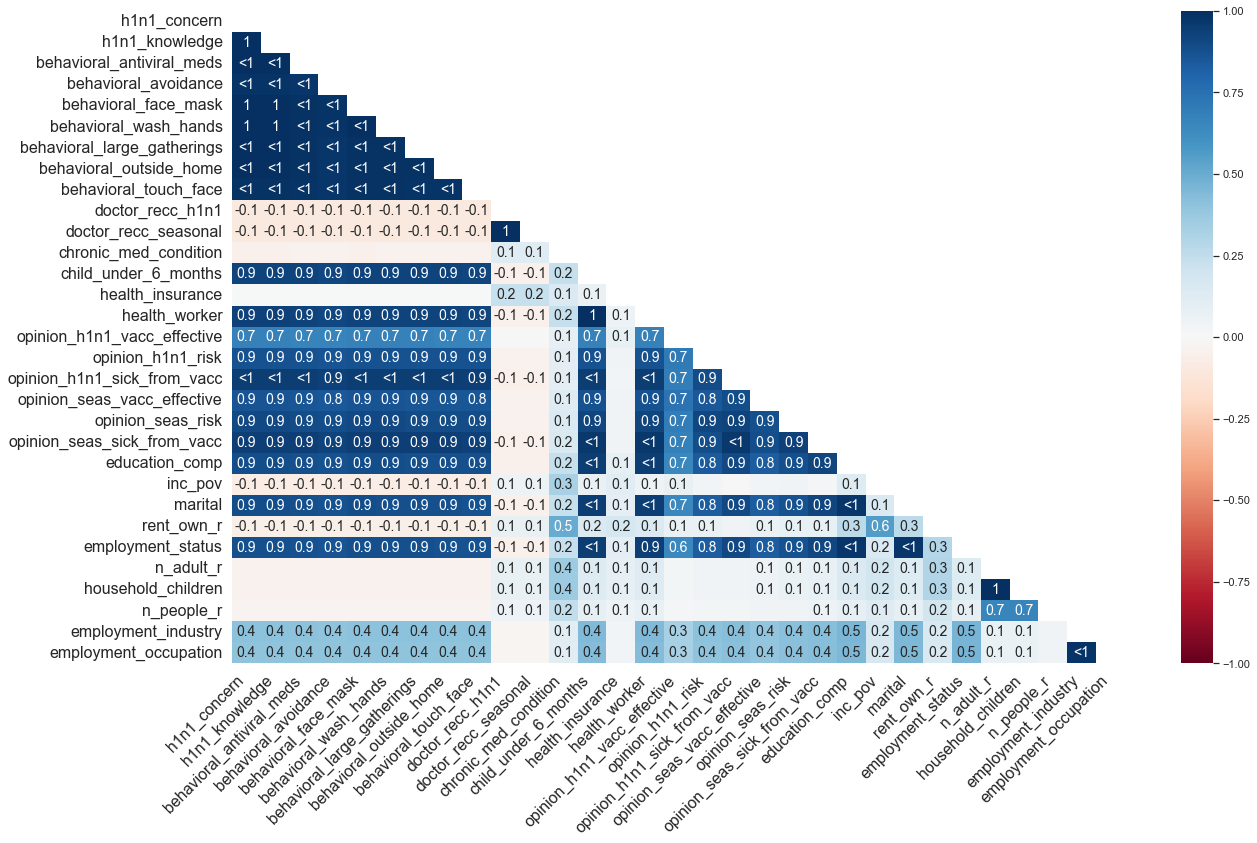

In [821]:
msno.heatmap(df)

we can see features share patterns   
- pattern_A
    - h1n1_concern
    - h1n1_knowledge
    - behavioral_antiviral_meds
    - behavioral_avoidance
    - behavioral_face_mask
    - behavioral_wash_hands
    - behavioral_large_gatherings
    - behavioral_outside_home
    - behavioral_touch_face
    - child_under_6_months
    - health_worker
    - opinion_h1n1_vacc_effective *
    - opinion_h1n1_risk
    - opinion_h1n1_sick_from_vacc
    - opinion_seas_vacc_effective
    - opinion_seas_risk
    - opinion_seas_sick_from_vacc
    - education_comp
    - marital
    - employment_status
- pattern_B
    - doctor_recc_h1n1
    - doctor_recc_seasonal
- pattern_C
    - n_adult_r
    - househole_children
    - n_people_r
- pattern_D
    - employment_industry
    - employment_occupation

    
chronic_med_condition, health_insurance, inc_pov, rent_own_r -> maybe MCAR 

total number of query : 38


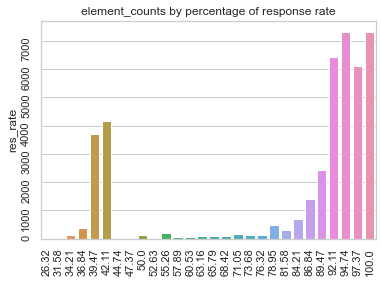

In [822]:
# response rate
nq=len(df.columns)-2
print(f'total number of query : {nq}')
df.isna().sum(axis=1)
df['res_rate']=df.isna().sum(axis=1).apply(lambda x: round((nq-x)/nq*100,2))
response=df['res_rate'].value_counts()
ax=sns.barplot(x=response.index,y=response)
ax.tick_params(rotation=90)
ax.set_title('element_counts by percentage of response rate');

In [823]:
#lazy people(the "res_rate<37"s) look minor and not important
#ProfileReport(df[df['res_rate']<37], title="Lazy people Profiling Report", explorative=True)

dummy variable of missing values

In [824]:
#dummy variable of missing values
df_MV=df[:].isna()
df_MV.columns=df_MV.columns.map(lambda x: f'{x}_mv')
for i in df_MV.columns:
    if df_MV[i].var()==0:
        df_MV.drop([i],axis=1,inplace=True)
#ProfileReport(df_MV, title="Missing values Profiling Report", explorative=True)

Handling Structurally missing data

<AxesSubplot:>

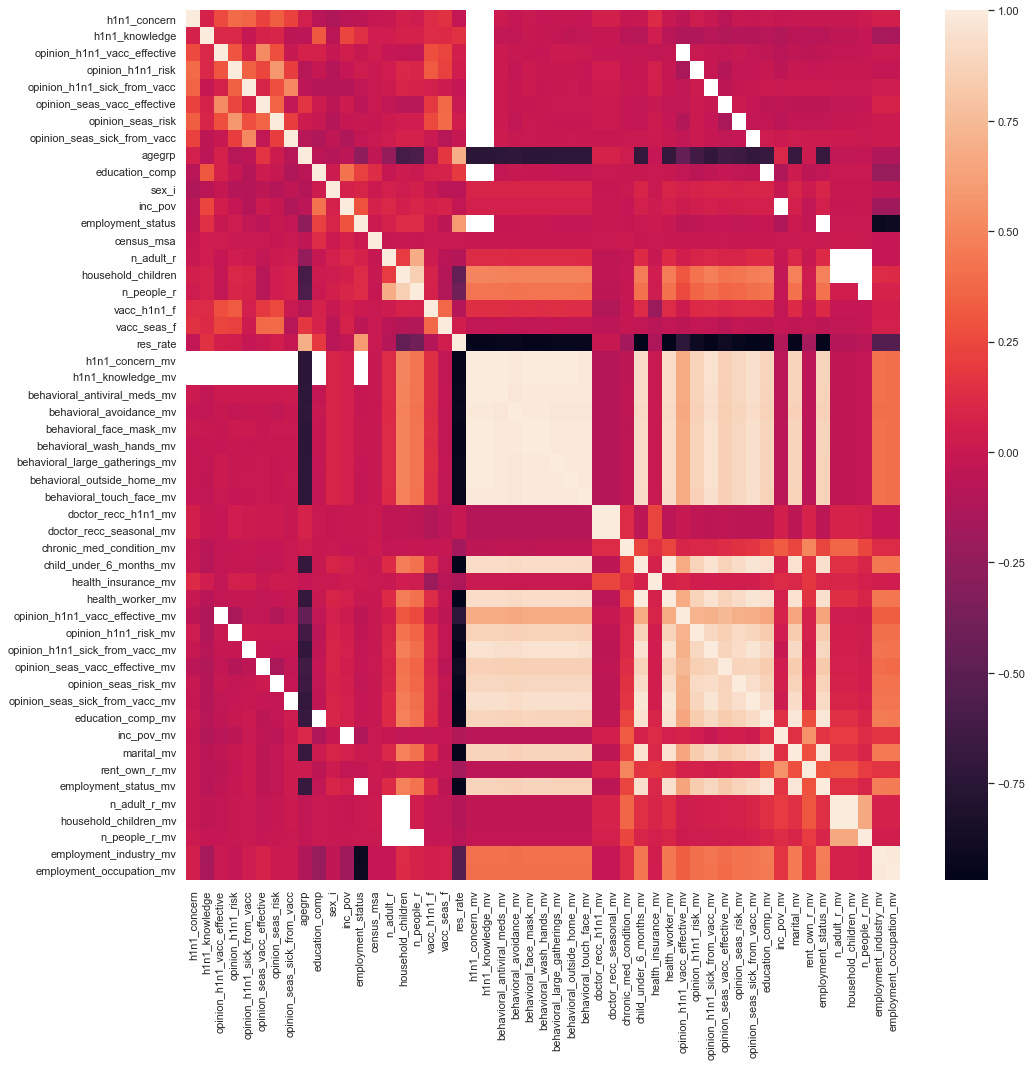

In [825]:
df_MV_corr=pd.concat([df,df_MV],axis=1)
df_MV_corr=df_MV_corr.corr()
fig, axs = plt.subplots(figsize=(16,16),nrows=1,ncols=1)
sns.heatmap(data=df_MV_corr,ax=axs)

maybe we can fill some MVs with age_group
- 1: '6 Months - 9 Years'
- 2: '10 - 17 Years'
- 3: '18 - 34 Years'
- 4: '35 - 44 Years'
- 5: '45 - 54 Years'
- 6: '55 - 64 Years'
- 7: '65+ Years'


In [826]:
#result means the number of MVs
df_age=pd.concat([df['agegrp'],df_MV],axis=1).groupby(by='agegrp').sum()
for i in df_age.columns:
    print(i)
    print(dict(df_age[i]))

h1n1_concern_mv
{1: 4330, 2: 4090, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
h1n1_knowledge_mv
{1: 4330, 2: 4090, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
behavioral_antiviral_meds_mv
{1: 4330, 2: 4090, 3: 14, 4: 11, 5: 18, 6: 9, 7: 47}
behavioral_avoidance_mv
{1: 4330, 2: 4090, 3: 17, 4: 18, 5: 42, 6: 66, 7: 109}
behavioral_face_mask_mv
{1: 4330, 2: 4090, 3: 5, 4: 2, 5: 3, 6: 7, 7: 7}
behavioral_wash_hands_mv
{1: 4330, 2: 4090, 3: 8, 4: 5, 5: 11, 6: 5, 7: 22}
behavioral_large_gatherings_mv
{1: 4330, 2: 4090, 3: 11, 4: 7, 5: 10, 6: 19, 7: 47}
behavioral_outside_home_mv
{1: 4330, 2: 4090, 3: 12, 4: 8, 5: 14, 6: 19, 7: 48}
behavioral_touch_face_mv
{1: 4330, 2: 4090, 3: 17, 4: 12, 5: 20, 6: 33, 7: 81}
doctor_recc_h1n1_mv
{1: 17, 2: 18, 3: 372, 4: 273, 5: 342, 6: 383, 7: 480}
doctor_recc_seasonal_mv
{1: 17, 2: 18, 3: 372, 4: 273, 5: 342, 6: 383, 7: 480}
chronic_med_condition_mv
{1: 68, 2: 53, 3: 277, 4: 199, 5: 209, 6: 205, 7: 306}
child_under_6_months_mv
{1: 4330, 2: 4090, 3: 265, 4: 195, 5: 179, 6: 170, 7: 220

In [827]:
#1,2,7그룹으로 결측치 채우기
for i in range(len(df)):
    if df['agegrp'][i] in (1,2):
        df['education_comp'][i]=1
        df['marital'][i]=False
        df['employment_status'][i]=0
        df['employment_industry'][i]='student'
        df['employment_occupation'][i]='student'
    elif df['agegrp'][i] ==7:
        df['employment_status'][i]=False
        df['employment_industry'][i]='homekeeper'
        df['employment_occupation'][i]='homekeeper'
pass;

C:\Users\gram\AppData\Local\Temp\ipykernel_18684\4025602450.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['education_comp'][i]=1
C:\Users\gram\AppData\Local\Temp\ipykernel_18684\4025602450.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['marital'][i]=False
C:\Users\gram\AppData\Local\Temp\ipykernel_18684\4025602450.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['employment_status'][i]=0
C:\Users\gram\AppData\Loc

응답률 42.11%인 그룹은 10~20대가 거의 대부분이고 백신을 맞을 확률이 높다.그리고 이들은 습관 관련 설문을 하지 않았다. 또한 이들이 다른 변수의 결측치를 채움으로써 해당 변수들의 해당 항목 중요도를 올림. EDA할때 agegrp에서 둘이 합쳐서 13%로 제일 중요도 높았음

In [828]:
df.drop(['res_rate'],axis=1,inplace=True)

In [829]:
# n_adult_r + househole_childrn = n_people_r 임을 이용하여 결측치 채우기
# If there is one MV among them, we can fill the MV
# 1 MV detection(MVs have 'True')
a=(~df_MV['n_adult_r_mv'] * df_MV['household_children_mv'] * ~df_MV['n_people_r_mv'])+(df_MV['n_adult_r_mv'] * ~df_MV['household_children_mv'] * ~df_MV['n_people_r_mv'])+(~df_MV['n_adult_r_mv'] * ~df_MV['household_children_mv'] * df_MV['n_people_r_mv'])
a.unique()

array([False])

In [830]:
#가설검정을 통해 결측여부가 어떤 변수와 연관있는지 알아보기
for i in df_MV.columns:
    for j in df.columns:
        obs=pd.crosstab(df_MV[i],df[j])
        a=scipy.stats.chi2_contingency(obs,correction=False)[1]
        b=scipy.stats.chi2_contingency(obs,correction=True)[1]
        if a<0.05 or b<0.05:
            print(f'{i} and {j} are dependent')


h1n1_concern_mv and doctor_recc_h1n1 are dependent
h1n1_concern_mv and doctor_recc_seasonal are dependent
h1n1_concern_mv and chronic_med_condition are dependent
h1n1_concern_mv and health_insurance are dependent
h1n1_concern_mv and agegrp are dependent
h1n1_concern_mv and education_comp are dependent
h1n1_concern_mv and raceeth4_i are dependent
h1n1_concern_mv and sex_i are dependent
h1n1_concern_mv and inc_pov are dependent
h1n1_concern_mv and marital are dependent
h1n1_concern_mv and employment_status are dependent
h1n1_concern_mv and census_region are dependent
h1n1_concern_mv and census_msa are dependent
h1n1_concern_mv and n_adult_r are dependent
h1n1_concern_mv and household_children are dependent
h1n1_concern_mv and n_people_r are dependent
h1n1_concern_mv and employment_industry are dependent
h1n1_concern_mv and employment_occupation are dependent
h1n1_concern_mv and state are dependent
h1n1_concern_mv and vacc_h1n1_f are dependent
h1n1_concern_mv and vacc_seas_f are dependent

##### Correlation

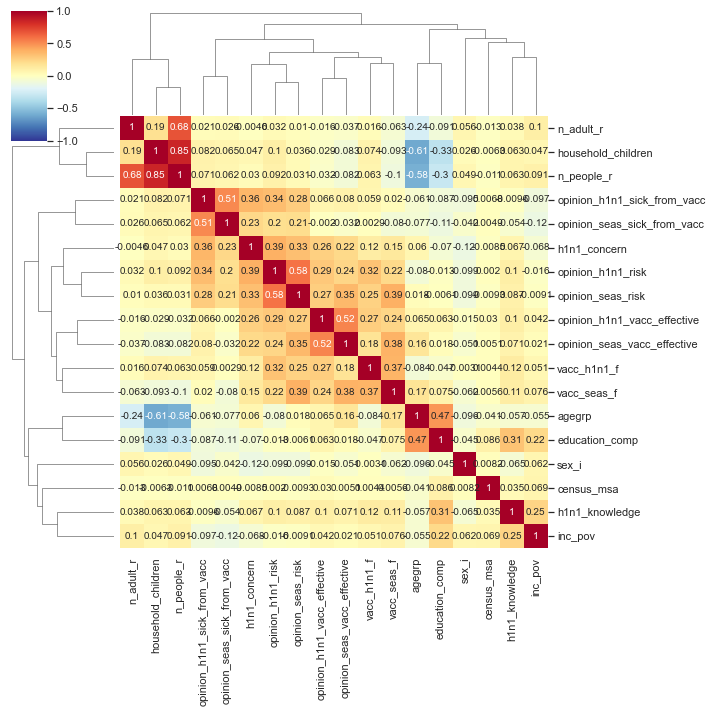

In [831]:
corr = df.corr(method='pearson')
sns.clustermap(corr, 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

##### Factor analysis

In [ ]:
#skip

##### Clustering

## Data Preprocessing

### Type casting

In [832]:
def type_casting(df):
    df['vacc_h1n1_f']=df['vacc_h1n1_f'].astype(bool)
    df['vacc_seas_f']=df['vacc_seas_f'].astype(bool)
    df['h1n1_concern']=df['h1n1_concern'].astype(pd.CategoricalDtype(ordered=True))
    df['h1n1_knowledge']=df['h1n1_knowledge'].astype(pd.CategoricalDtype(ordered=True))
    df['behavioral_antiviral_meds']=df['behavioral_antiviral_meds'].astype(bool)
    df['behavioral_avoidance']=df['behavioral_avoidance'].astype(bool)
    df['behavioral_face_mask']=df['behavioral_face_mask'].astype(bool)
    df['behavioral_wash_hands']=df['behavioral_wash_hands'].astype(bool)
    df['behavioral_large_gatherings']=df['behavioral_large_gatherings'].astype(bool)
    df['behavioral_outside_home']=df['behavioral_outside_home'].astype(bool)
    df['behavioral_touch_face']=df['behavioral_touch_face'].astype(bool)
    df['doctor_recc_h1n1']=df['doctor_recc_h1n1'].astype(bool)
    df['doctor_recc_seasonal']=df['doctor_recc_seasonal'].astype(bool)
    df['chronic_med_condition']=df['chronic_med_condition'].astype(bool)
    df['child_under_6_months']=df['child_under_6_months'].astype(bool)
    df['health_insurance']=df['health_insurance'].astype(bool)
    df['health_worker']=df['health_worker'].astype(bool)
    df['opinion_h1n1_vacc_effective']=df['opinion_h1n1_vacc_effective'].astype(pd.CategoricalDtype(ordered=True))
    df['opinion_h1n1_risk']=df['opinion_h1n1_risk'].astype(pd.CategoricalDtype(ordered=True))
    df['opinion_h1n1_sick_from_vacc']=df['opinion_h1n1_sick_from_vacc'].astype(pd.CategoricalDtype(ordered=True))
    df['opinion_seas_vacc_effective']=df['opinion_seas_vacc_effective'].astype(pd.CategoricalDtype(ordered=True))
    df['opinion_seas_risk']=df['opinion_seas_risk'].astype(pd.CategoricalDtype(ordered=True))
    df['opinion_seas_sick_from_vacc']=df['opinion_seas_sick_from_vacc'].astype(pd.CategoricalDtype(ordered=True))
    df['agegrp']=df['agegrp'].astype(pd.CategoricalDtype(ordered=True))
    df['education_comp']=df['education_comp'].astype(pd.CategoricalDtype(ordered=True))
    df['raceeth4_i']=df['raceeth4_i'].astype('category')
    df['sex_i']=df['sex_i'].astype(bool)
    df['inc_pov']=df['inc_pov'].astype(pd.CategoricalDtype(ordered=True))
    df['marital']=df['marital'].astype(bool)
    df['rent_own_r']=df['rent_own_r'].astype(bool)
    df['employment_status']=df['employment_status'].astype(pd.CategoricalDtype(ordered=True))
    df['census_region']=df['census_region'].astype('category')
    df['census_msa']=df['census_msa'].astype(pd.CategoricalDtype(ordered=True))
    df['n_adult_r']=df['n_adult_r'].astype(pd.CategoricalDtype(ordered=True))
    df['household_children']=df['household_children'].astype(pd.CategoricalDtype(ordered=True))
    df['n_people_r']=df['n_people_r'].astype(pd.CategoricalDtype(ordered=True))
    df['employment_industry']=df['employment_industry'].astype('category')
    df['employment_occupation']=df['employment_occupation'].astype('category')
    df['hhs_region']=df['hhs_region'].astype('category')
    df['state']=df['state'].astype('category')
    return df
df = type_casting(df)

### Feature Engineering

In [835]:
df_temp=df.drop(['vacc_seas_f'],axis=1)
TARGET='vacc_h1n1_f'
FEATURES=[column for column in df_temp.columns if column!=TARGET]
X_train,X_val,y_train,y_val = train_test_split(df_temp[FEATURES],df_temp[TARGET],test_size=0.3,random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((29507, 38), (29507,), (12647, 38), (12647,))

In [836]:
from sklearn.utils.multiclass import type_of_target
type_of_target(y_train)

'binary'

In [837]:
clf = LGBMClassifier(
    n_jobs=-1,
    n_estimators=1000,
    learning_rate=0.02,
    num_leaves=32,
    subsample=0.8,
    max_depth=12,
    silent=-1,
    verbose=-1
)

clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],eval_metric='auc',verbose=100,early_stopping_rounds=50)

C:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is depr

[100]	training's auc: 0.835264	training's binary_logloss: 0.419376	valid_1's auc: 0.811542	valid_1's binary_logloss: 0.433795
[200]	training's auc: 0.857362	training's binary_logloss: 0.391572	valid_1's auc: 0.816331	valid_1's binary_logloss: 0.423656
[300]	training's auc: 0.874137	training's binary_logloss: 0.373679	valid_1's auc: 0.817555	valid_1's binary_logloss: 0.421505


LGBMClassifier(learning_rate=0.02, max_depth=12, n_estimators=1000,
               num_leaves=32, silent=-1, subsample=0.8, verbose=-1)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

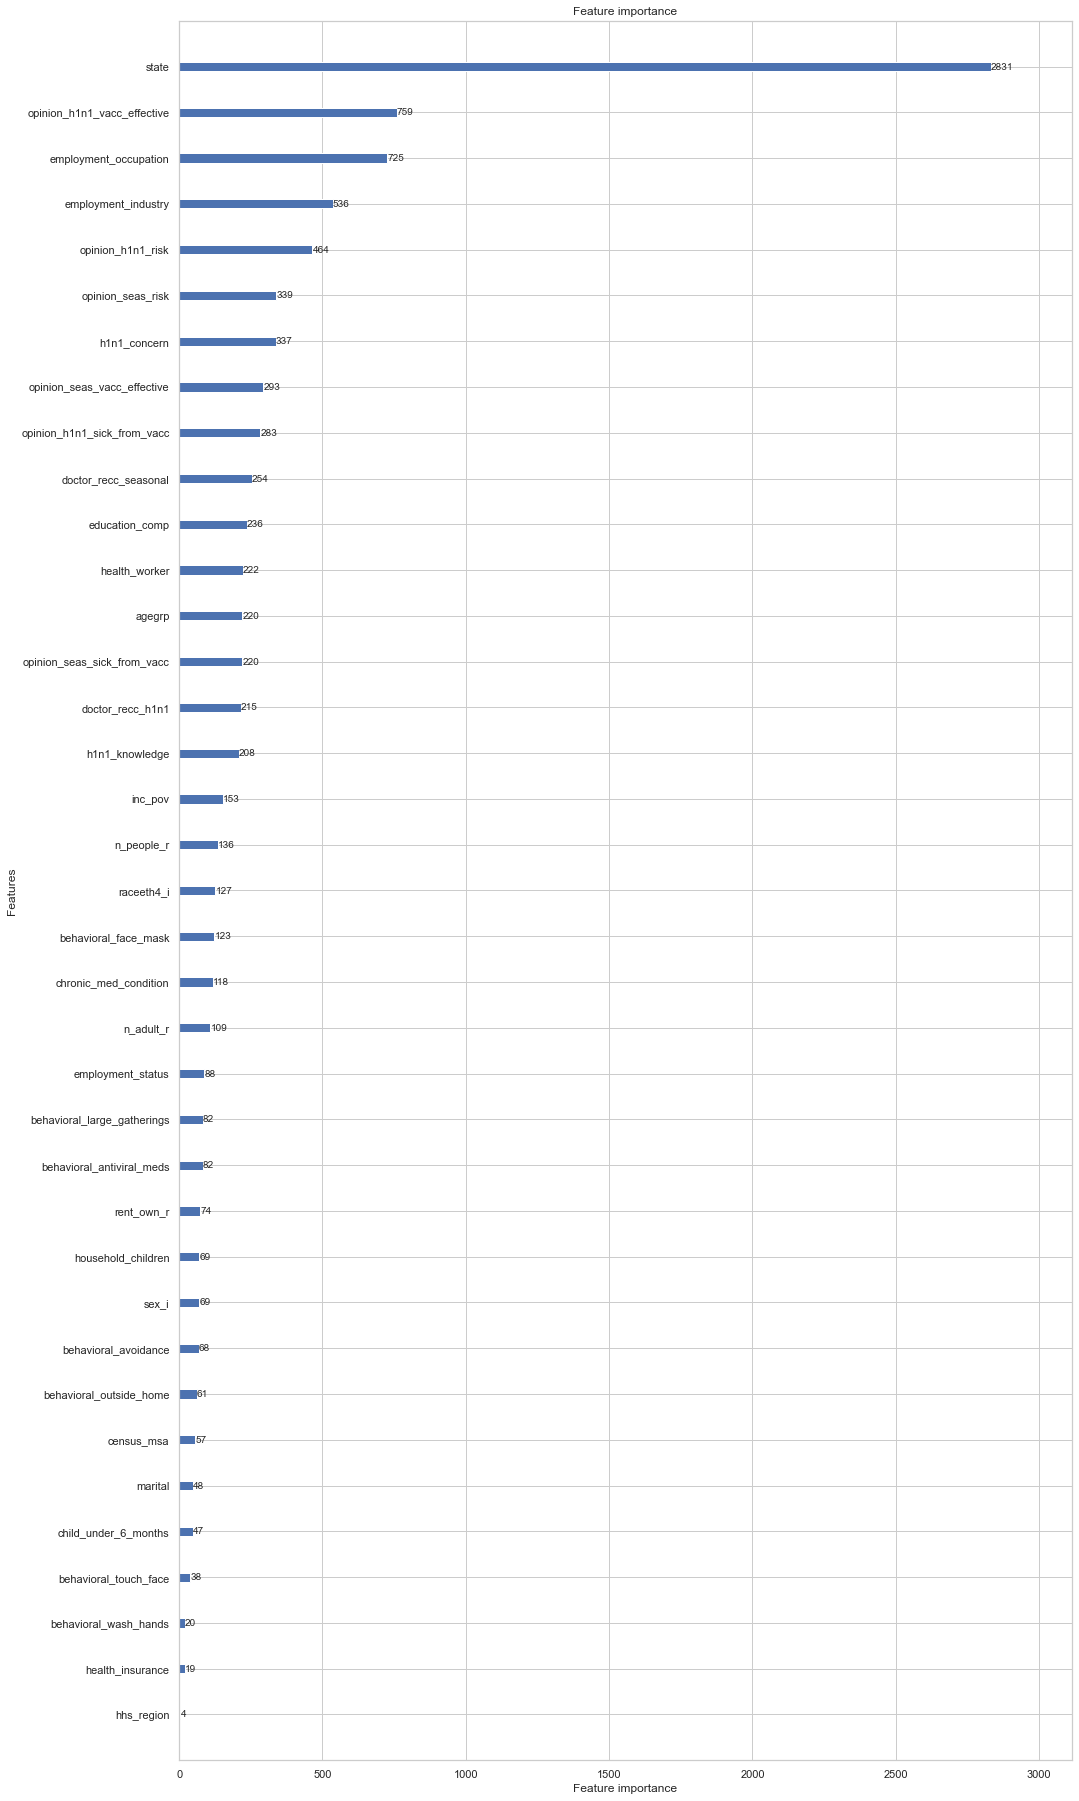

In [838]:
from lightgbm import plot_importance
plot_importance(clf,figsize=(16,32))

### Feature Selection by filter methods

In [ ]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)
        
        if round(d['IV'].sum(),6)>0.5:
          print('***********************************found************************')

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [ ]:
iv, woe = iv_woe(data = df, target = 'vacc_h1n1_f', bins=10, show_woe = True)
print(iv)
print(woe)

Information value of h1n1_concern is 0.079903
       Variable         Cutoff      N  Events  % of Events  Non-Events  \
0  h1n1_concern  (-0.001, 1.0]  14502    2352     0.330616       12150   
1  h1n1_concern     (1.0, 2.0]  13441    3083     0.433371       10358   
2  h1n1_concern     (2.0, 3.0]   5791    1679     0.236013        4112   

   % of Non-Events       WoE        IV  
0         0.456424 -0.322465  0.040569  
1         0.389106  0.107742  0.004769  
2         0.154470  0.423887  0.034565  
Information value of h1n1_knowledge is 0.085543
         Variable         Cutoff      N  Events  % of Events  Non-Events  \
0  h1n1_knowledge  (-0.001, 1.0]  21732    3783     0.531768       17949   
1  h1n1_knowledge     (1.0, 2.0]  12002    3331     0.468232        8671   

   % of Non-Events       WoE        IV  
0         0.674267 -0.237419  0.033832  
1         0.325733  0.362887  0.051711  
Information value of behavioral_antiviral_meds is 0.011504
                    Variable  Cuto

### Dimension Reduction

PCA

### Encoding categorical variables

In [111]:
#Binary encoder
binary_encoder=category_encoders.binary.BinaryEncoder(cols=categorical_encoding_needed,handle_missing='return_nan')
df_encode=binary_encoder.fit_transform(df)

### Multiple imputation

In [112]:
col_type={'h1n1_concern': 'B',
 'h1n1_knowledge': 'B',
 'behavioral_antiviral_meds': 'A',
 'behavioral_avoidance': 'A',
 'behavioral_face_mask': 'A',
 'behavioral_wash_hands': 'A',
 'behavioral_large_gatherings': 'A',
 'behavioral_outside_home': 'A',
 'behavioral_touch_face': 'A',
 'doctor_recc_h1n1': 'A',
 'doctor_recc_seasonal': 'A',
 'chronic_med_condition': 'A',
 'child_under_6_months': 'A',
 'health_insurance': 'A',
 'health_worker': 'A',
 'opinion_h1n1_vacc_effective': 'B',
 'opinion_h1n1_risk': 'B',
 'opinion_h1n1_sick_from_vacc': 'B',
 'opinion_seas_vacc_effective': 'B',
 'opinion_seas_risk': 'B',
 'opinion_seas_sick_from_vacc': 'B',
 'agegrp': 'B',
 'education_comp': 'B',
 'raceeth4_i_0': 'A',
 'raceeth4_i_1': 'A',
 'raceeth4_i_2': 'A',
 'sex_i': 'A',
 'inc_pov': 'B',
 'marital': 'A',
 'rent_own_r': 'A',
 'employment_status': 'B',
 'census_region_0': 'A',
 'census_region_1': 'A',
 'census_region_2': 'A',
 'census_msa': 'B',
 'n_adult_r': 'B',
 'household_children': 'B',
 'n_people_r': 'B',
 'employment_industry_0': 'A',
 'employment_industry_1': 'A',
 'employment_industry_2': 'A',
 'employment_industry_3': 'A',
 'employment_industry_4': 'A',
 'employment_occupation_0': 'A',
 'employment_occupation_1': 'A',
 'employment_occupation_2': 'A',
 'employment_occupation_3': 'A',
 'employment_occupation_4': 'A',
 'hhs_region_0': 'A',
 'hhs_region_1': 'A',
 'hhs_region_2': 'A',
 'hhs_region_3': 'A',
 'state_0': 'A',
 'state_1': 'A',
 'state_2': 'A',
 'state_3': 'A',
 'state_4': 'A',
 'state_5': 'A'}

In [113]:
try:
    targets=df_encode[['vacc_seas_f','vacc_h1n1_f']]
    df_encode.drop(['vacc_h1n1_f','vacc_seas_f'],axis=1,inplace=True)
except:
    pass
strategies=['default predictive', 'least squares', 'stochastic', 'binary logistic', 'multinomial logistic', 'bayesian least squares', 'bayesian binary logistic', 'pmm', 'lrd', 'default univariate', 'default time', 'mean', 'median', 'mode', 'random', 'norm', 'categorical', 'interpolate', 'locf', 'nocb', 'normal unit variance']

for i in itertools.combinations(strategies,2):
    input_strategy1={}
    input_strategy2={}
    for j in col_type:
        if col_type[j]=='A':
            input_strategy1[j]=i[0]
            input_strategy2[j]=i[1]
        else:
            input_strategy1[j]=i[1]
            input_strategy2[j]=i[0]
            
    try:
        mice = MiceImputer(strategy=input_strategy1, return_list=True)
        mice.fit_transform(df_encode)
        print(col_type)
    except Exception as e:
        print(e)
    try:
        mice = MiceImputer(strategy=input_strategy2, return_list=True)
        mice.fit_transform(df_encode)
        print(col_type)
    except Exception as e:
        print(e)

C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached whi

least squares not appropriate for Series employment_status of type object.
least squares not appropriate for Series behavioral_antiviral_meds of type object.


C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached whi

stochastic not appropriate for Series employment_status of type object.
stochastic not appropriate for Series behavioral_antiviral_meds of type object.
Binary requires 2 categories. Use multinomial instead.


C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnin

Chain 3 failed.


C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary i

X has 46 features per sample; expecting 57


C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached whi

In [114]:
try:
    df_encode.drop(['vacc_seas_f'],axis=1,inplace=True)
except:
    pass

import itertools
for cols in itertools.combinations(df_encode.columns,3):
    cols=list(cols)
    a=df_encode[cols]
    mice_strategy={}
    for column in a.columns:
        if a.dtypes.to_dict()[column]=='bool':
            mice_strategy[column]= 'binary logistic'
        else:
            mice_strategy[column]= 'pmm'
    try:
        print(cols)
        mice = MiceImputer(strategy=mice_strategy, imp_kwgs={"pmm": {"fill_value": "random"}}, visit="left-to-right", return_list=True)
        mice.fit_transform(a)
        print(1)
    except:
        print(0)

['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds']
0
['h1n1_concern', 'h1n1_knowledge', 'behavioral_avoidance']
0
['h1n1_concern', 'h1n1_knowledge', 'behavioral_face_mask']
0
['h1n1_concern', 'h1n1_knowledge', 'behavioral_wash_hands']
0
['h1n1_concern', 'h1n1_knowledge', 'behavioral_large_gatherings']
0
['h1n1_concern', 'h1n1_knowledge', 'behavioral_outside_home']
0
['h1n1_concern', 'h1n1_knowledge', 'behavioral_touch_face']
0
['h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1']
0
['h1n1_concern', 'h1n1_knowledge', 'doctor_recc_seasonal']
0
['h1n1_concern', 'h1n1_knowledge', 'chronic_med_condition']
0
['h1n1_concern', 'h1n1_knowledge', 'child_under_6_months']
0
['h1n1_concern', 'h1n1_knowledge', 'health_insurance']
0
['h1n1_concern', 'h1n1_knowledge', 'health_worker']
0
['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective']


C:\Users\gram\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\gram\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\gram\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\gram\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, beta, alpha]


### Scaling

## Modeling and Evaluation

### Split data

### baseline model and 1th analysis

### Evaluation 1

### Feature engineering and 2nd analysis

### Evaluation 2

## Conclusion